In [8]:
# Libraries we are going to use here #
library(VIM)
library(Amelia)
library(Hmisc)
library(corrplot)
library(RColorBrewer)
library(gmodels)


Loading required package: colorspace
Loading required package: grid
Loading required package: data.table

Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

VIM is ready to use. 
 Since version 4.0.0 the GUI is in its own package VIMGUI.

          Please use the package to use the new (and old) GUI.

Suggestions and bug-reports can be submitted at: https://github.com/alexkowa/VIM/issues

Attaching package: 'VIM'

The following object is masked from 'package:datasets':

    sleep

Warning message:
"package 'Amelia' was built under R version 3.5.2"Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.5, built: 2018-05-07)
## Copyright (C) 2005-2019 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


In [2]:
###=== Importing the imputed dataset with no blanks no year col ===###
realestate<-as.data.frame.array(read.csv("F:\\melb.realstate.all.files\\InputDatasets\\re.imputed.noblanks.noyear.csv", header = T, sep = ",", strip.white = T, stringsAsFactors = T, na.strings = "" ))


In [3]:
##== Checking for NAs ==##
realestate[!complete.cases(realestate),]


Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude


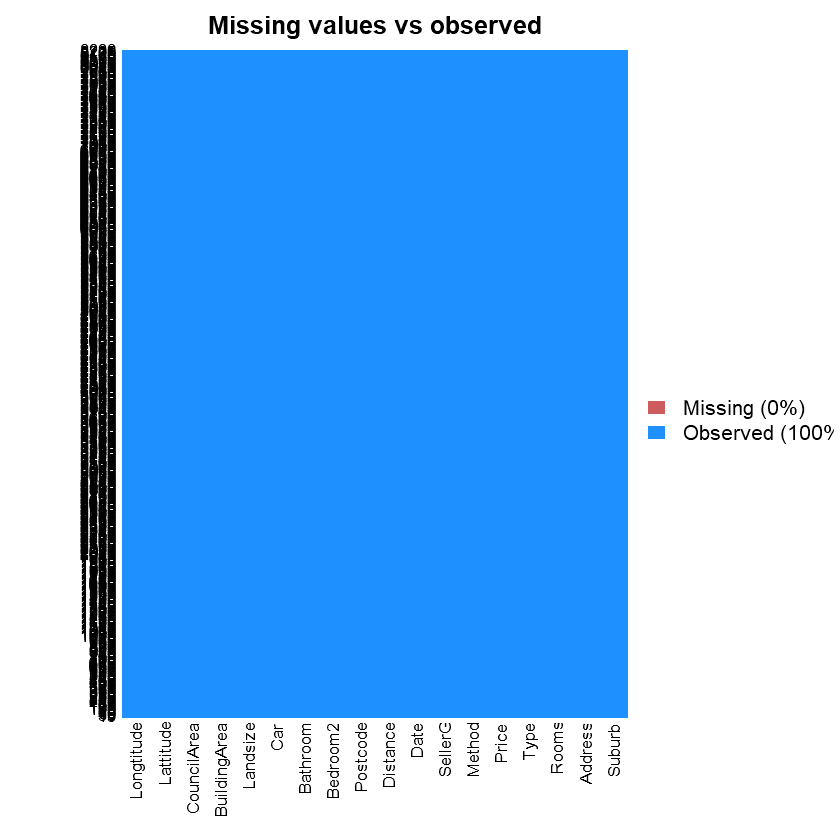


 Variables sorted by number of missings: 
     Variable Count
       Suburb     0
      Address     0
        Rooms     0
         Type     0
        Price     0
       Method     0
      SellerG     0
         Date     0
     Distance     0
     Postcode     0
     Bedroom2     0
     Bathroom     0
          Car     0
     Landsize     0
 BuildingArea     0
  CouncilArea     0
    Lattitude     0
   Longtitude     0


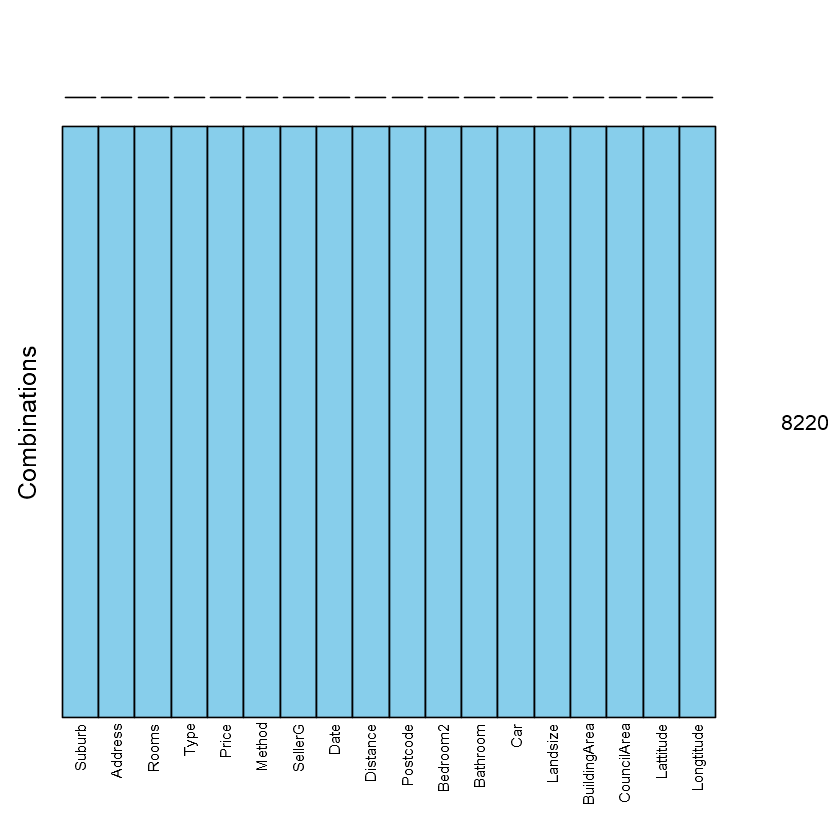

In [9]:
#==checking for NAs with graphs and plots ==#
missmap(realestate, legend = TRUE, col = c("indianred", "dodgerblue"), main = "Missing values vs observed", y.cex = 0.8, x.cex = 0.8, rank.order = TRUE, margins = c(5, 5))

aggr(realestate, prop = F, combined=T,only.miss = TRUE, cex.axis = 0.7, rank.order = TRUE, sortVars = TRUE)


In [11]:
##== Creating Derived Columns ==##

#= Difference in Days =#
realestate$Days.diff <- as.Date(as.character(realestate$Date), format="%d-%m-%Y")-
  as.Date(as.character("01-01-16"), format="%d-%m-%Y")
 realestate$Days.diff<-as.numeric(realestate$Days.diff)

In [12]:
#= Distance Bucket =#
realestate$Dist.bucket<-cut(realestate$Distance, breaks = c(-Inf, 3, 6, 9, 12, Inf), labels = c("very near", "near", "medium", "far", "very far"))

In [13]:
#= Price Bucket =#
realestate$Price.bucket<-cut(realestate$Price, breaks = c(-Inf, 400000, 800000, 1600000, 2500000, Inf), labels = c("<4L", "4L-8L", "8L- 16L", "16L-25L", ">25L"))


In [14]:
#= In Months =#
realestate$Months<-cut(realestate$Days.diff, breaks = c(-Inf,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517, Inf), labels = c("Jan'16","Feb'16","Mar'16","Apr'16","May'16","Jun'16","Jul'16","Aug'16","Sep'16","Oct'16","Nov'16","Dec'16","Jan'17","Feb'17","Mar'17","Apr'17","May'17","Jun'17"))
realestate$Months<-as.factor(realestate$Months)


In [15]:
##=== Converting Rooms, Postcode, Bedroom2, Bathroom, Car, as factor & Date into date format ===##
realestate$Postcode<-as.factor(realestate$Postcode)
realestate$Rooms<-as.factor(realestate$Rooms)
realestate$Bedroom2<-as.factor(realestate$Bedroom2)
realestate$Bathroom<-as.factor(realestate$Bathroom)
realestate$Car<-as.factor(realestate$Car)
realestate$Type<-as.factor(realestate$Type)


In [16]:
##===  creating new Data-Set excluding Address, Date & Days.Diff ===##
refined.realestate<-realestate[,-c(2,8,19)]


In [17]:
str(refined.realestate)

'data.frame':	8220 obs. of  19 variables:
 $ Suburb      : chr  "Abbotsford" "Abbotsford" "Abbotsford" "Abbotsford" ...
 $ Rooms       : Factor w/ 8 levels "1","2","3","4",..: 2 2 3 3 4 2 3 2 3 2 ...
 $ Type        : Factor w/ 3 levels "h","t","u": 1 1 1 1 1 1 1 1 1 1 ...
 $ Price       : int  1480000 1035000 1465000 850000 1600000 941000 1876000 1636000 1000000 1097000 ...
 $ Method      : chr  "S" "S" "SP" "PI" ...
 $ SellerG     : chr  "Biggin" "Biggin" "Biggin" "Biggin" ...
 $ Distance    : num  2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 ...
 $ Postcode    : Factor w/ 92 levels "3000","3002",..: 38 38 38 38 38 38 38 38 38 38 ...
 $ Bedroom2    : Factor w/ 11 levels "0","1","2","3",..: 3 3 4 4 4 3 5 3 4 4 ...
 $ Bathroom    : Factor w/ 9 levels "0","1","2","3",..: 2 2 3 3 2 2 3 2 2 2 ...
 $ Car         : Factor w/ 9 levels "0","1","2","3",..: 2 1 1 2 3 1 1 3 2 3 ...
 $ Landsize    : num  202 156 134 94 120 ...
 $ BuildingArea: num  123 79 150 123 142 ...
 $ CouncilArea : chr  "Yarra" "

In [18]:
##=== Subsetting all the continuous variables=== #
re.analysis.cont<-refined.realestate[,c(4,7,12,13)];names(re.analysis.cont)
str(re.analysis.cont)


[1] "Price"        "Distance"     "Landsize"     "BuildingArea"

'data.frame':	8220 obs. of  4 variables:
 $ Price       : int  1480000 1035000 1465000 850000 1600000 941000 1876000 1636000 1000000 1097000 ...
 $ Distance    : num  2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 ...
 $ Landsize    : num  202 156 134 94 120 ...
 $ BuildingArea: num  123 79 150 123 142 ...


In [19]:
##=== Subsetting all the categorical variables=== #
re.analysis.cate<-refined.realestate[,-c(4,7,12,13,15,16)];names(re.analysis.cate)

[1] "Suburb"       "Rooms"        "Type"         "Method"       "SellerG"     
 [6] "Postcode"     "Bedroom2"     "Bathroom"     "Car"          "CouncilArea" 
[11] "Dist.bucket"  "Price.bucket" "Months"

In [20]:
#=== Dataset without Lattitude and Lattitude ===#
re.analysis<-refined.realestate[,-c(15,16)]


In [23]:
###=== Univariant Analysis ===###

str(re.analysis)
describe(re.analysis)
dim(re.analysis)
names(re.analysis)

'data.frame':	8220 obs. of  17 variables:
 $ Suburb      : chr  "Abbotsford" "Abbotsford" "Abbotsford" "Abbotsford" ...
 $ Rooms       : Factor w/ 8 levels "1","2","3","4",..: 2 2 3 3 4 2 3 2 3 2 ...
 $ Type        : Factor w/ 3 levels "h","t","u": 1 1 1 1 1 1 1 1 1 1 ...
 $ Price       : int  1480000 1035000 1465000 850000 1600000 941000 1876000 1636000 1000000 1097000 ...
 $ Method      : chr  "S" "S" "SP" "PI" ...
 $ SellerG     : chr  "Biggin" "Biggin" "Biggin" "Biggin" ...
 $ Distance    : num  2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 ...
 $ Postcode    : Factor w/ 92 levels "3000","3002",..: 38 38 38 38 38 38 38 38 38 38 ...
 $ Bedroom2    : Factor w/ 11 levels "0","1","2","3",..: 3 3 4 4 4 3 5 3 4 4 ...
 $ Bathroom    : Factor w/ 9 levels "0","1","2","3",..: 2 2 3 3 2 2 3 2 2 2 ...
 $ Car         : Factor w/ 9 levels "0","1","2","3",..: 2 1 1 2 3 1 1 3 2 3 ...
 $ Landsize    : num  202 156 134 94 120 ...
 $ BuildingArea: num  123 79 150 123 142 ...
 $ CouncilArea : chr  "Yarra" "

re.analysis 

 17  Variables      8220  Observations
--------------------------------------------------------------------------------
Suburb 
       n  missing distinct 
    8220        0      140 

lowest : Abbotsford         Aberfeldie         Airport West       Albert Park        Albion            
highest: Williamstown       Williamstown North Windsor            Yallambie          Yarraville        
--------------------------------------------------------------------------------
Rooms 
       n  missing distinct 
    8220        0        8 
                                                          
Value          1     2     3     4     5     6     7     8
Frequency     97  1972  3919  1768   415    36     5     8
Proportion 0.012 0.240 0.477 0.215 0.050 0.004 0.001 0.001
--------------------------------------------------------------------------------
Type 
       n  missing distinct 
    8220        0        3 
                            
Value          h     t     u
Frequency   

[1] 8220   17

[1] "Suburb"       "Rooms"        "Type"         "Price"        "Method"      
 [6] "SellerG"      "Distance"     "Postcode"     "Bedroom2"     "Bathroom"    
[11] "Car"          "Landsize"     "BuildingArea" "CouncilArea"  "Dist.bucket" 
[16] "Price.bucket" "Months"

In [25]:
library(psych)



Attaching package: 'psych'

The following object is masked from 'package:Hmisc':

    describe

The following objects are masked from 'package:ggplot2':

    %+%, alpha



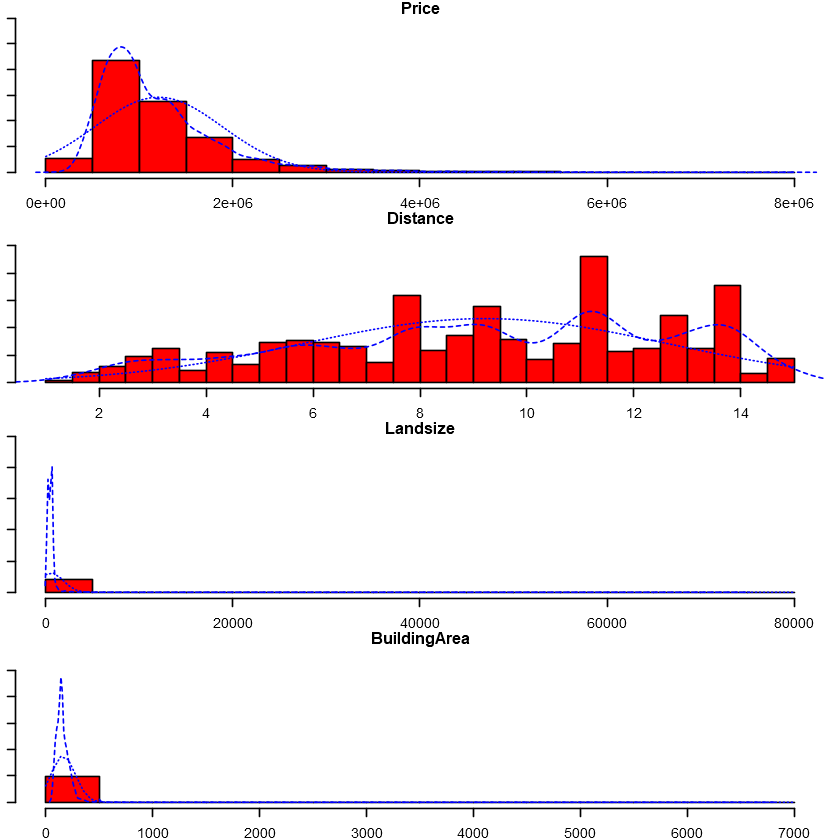

In [26]:

##== Histogram of continuos variables ==##
multi.hist(re.analysis.cont,freq = F, nrow = 4, bcol = "red",dcol = "blue") # Not plotting for Latti & Longti



        h         u         t 
80.425791 11.313869  8.260341 

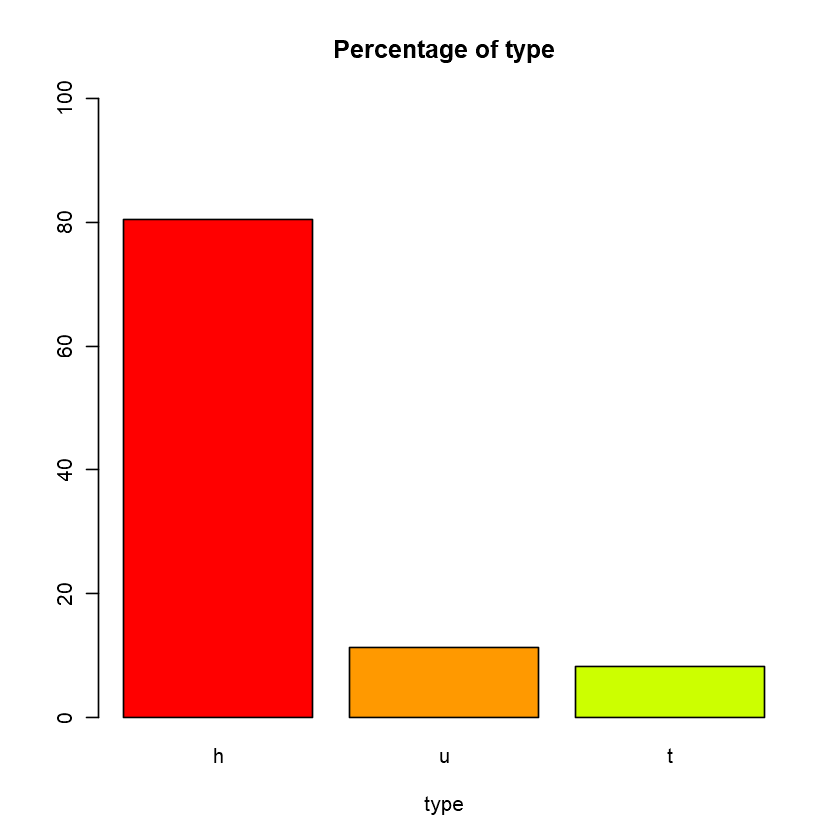

In [27]:
##== Tables & Barplots ==##

#= Types =#
table.type<-table(refined.realestate$Type)
typepercent<-prop.table(sort(table.type, decreasing = T))*100;typepercent
barplot(typepercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of type",xlab = "type")



         S         PI         SP         VB         SA 
68.8199513 12.1532847 10.8637470  7.7980535  0.3649635 

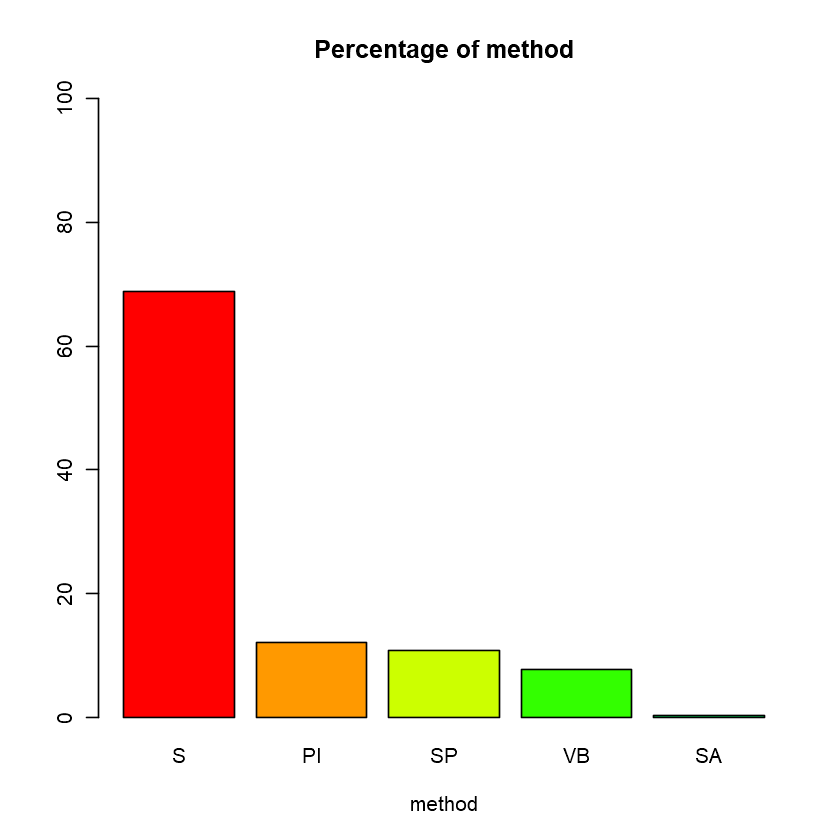

In [28]:
#= Methods =#
table.Method<-table(refined.realestate$Method)
methodpercent<-prop.table(sort(table.Method, decreasing = T))*100;methodpercent
barplot(methodpercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of method",xlab = "method")



       Nelson        Jellis         Barry hockingstuart      Marshall 
    13.418491     10.133820      8.296837      8.223844      6.119221 
       Buxton           Ray          Brad        Biggin      Woodards 
     4.939173      3.941606      3.029197      2.810219      2.299270 

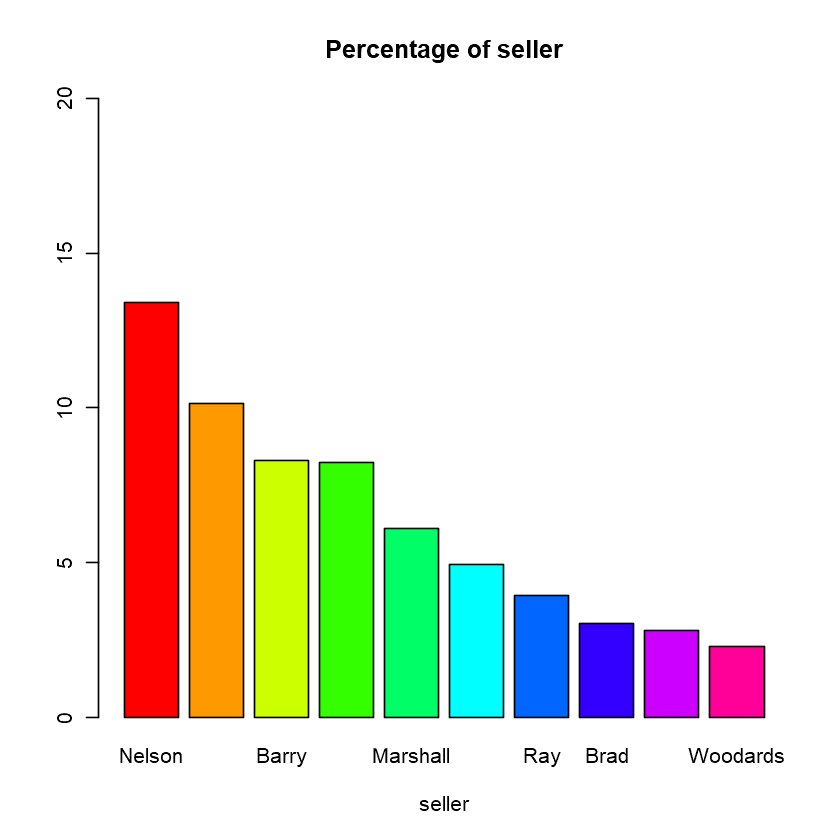

In [29]:
#= Sellers =#
table.Seller<-table(refined.realestate$SellerG)
sellerpercent<-head(prop.table(sort(table.Seller, decreasing = T))*100,10);sellerpercent
barplot(sellerpercent,ylim = c(0,20),col = rainbow(10),main = "Percentage of seller",xlab = "seller")



     Reservoir Bentleigh East        Preston       Richmond        Glenroy 
      3.953771       2.700730       2.396594       2.068127       1.812652 
     Brunswick       Brighton   Balwyn North    Pascoe Vale         Coburg 
      1.776156       1.751825       1.727494       1.678832       1.654501 

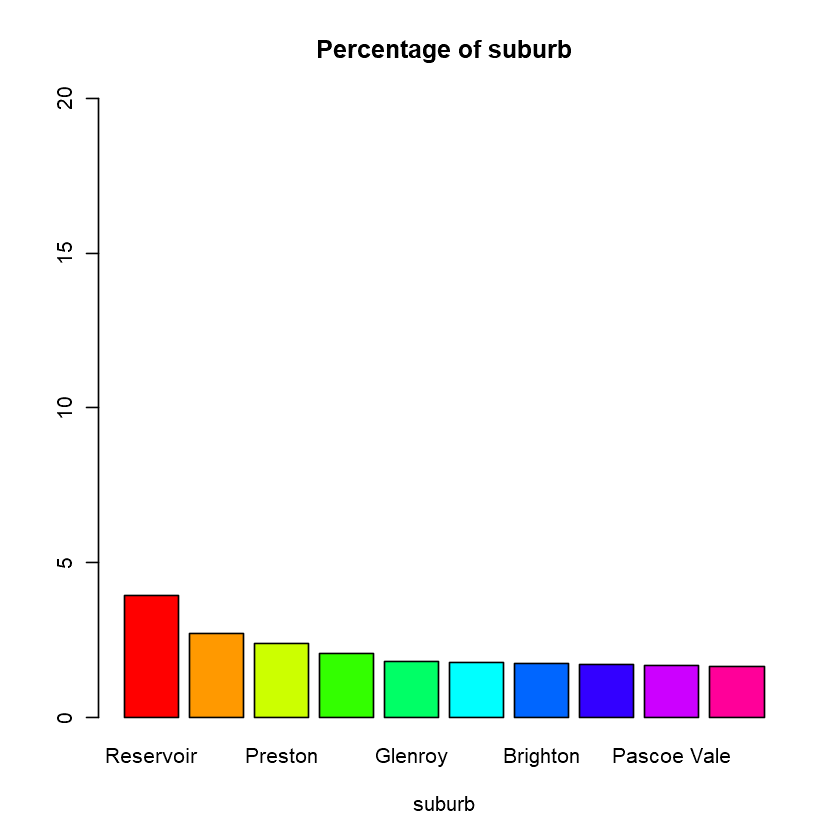

In [30]:
#= Suburbs =#
table.Suburb<-table(refined.realestate$Suburb)
suburbpercent<-head(prop.table(sort(table.Suburb, decreasing = T))*100,10);suburbpercent
barplot(suburbpercent,ylim = c(0,20),col = rainbow(10),main = "Percentage of suburb",xlab = "suburb")



          3           2           4           5           1           6 
47.67639903 23.99026764 21.50851582  5.04866180  1.18004866  0.43795620 
          8           7 
 0.09732360  0.06082725 

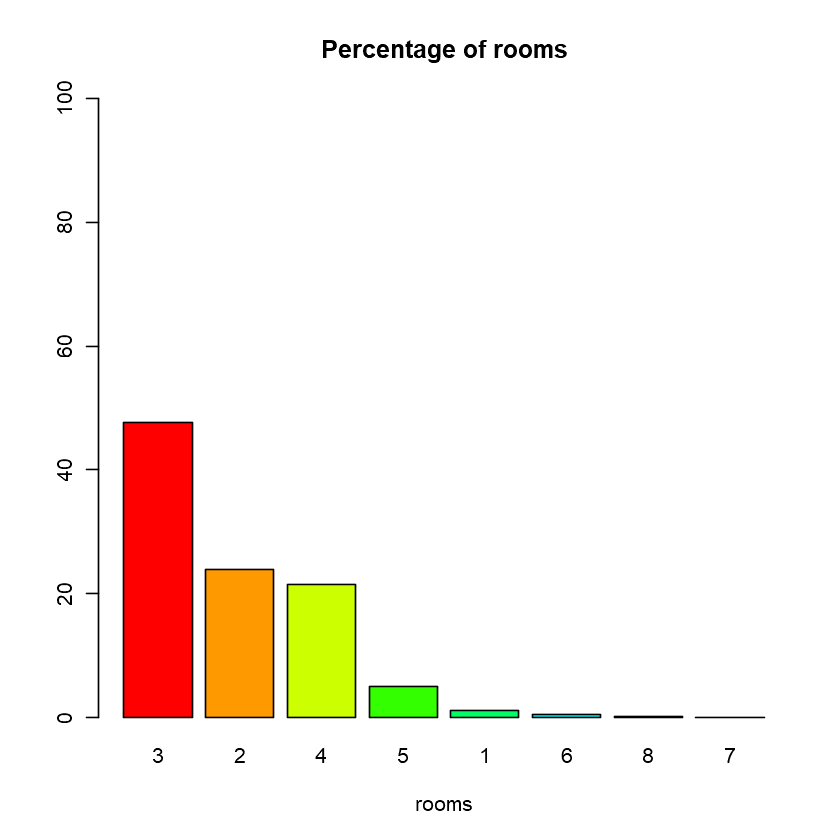

In [31]:
#= Rooms =#
table.Rooms<-table(refined.realestate$Rooms)
roomspercent<-prop.table(sort(table.Rooms, decreasing = T))*100;roomspercent
barplot(roomspercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of rooms",xlab = "rooms")



          3           2           4           5           1           6 
47.91970803 25.08515815 20.38929440  4.59854015  1.35036496  0.38929440 
          0           7           8           9          20 
 0.10948905  0.06082725  0.04866180  0.03649635  0.01216545 

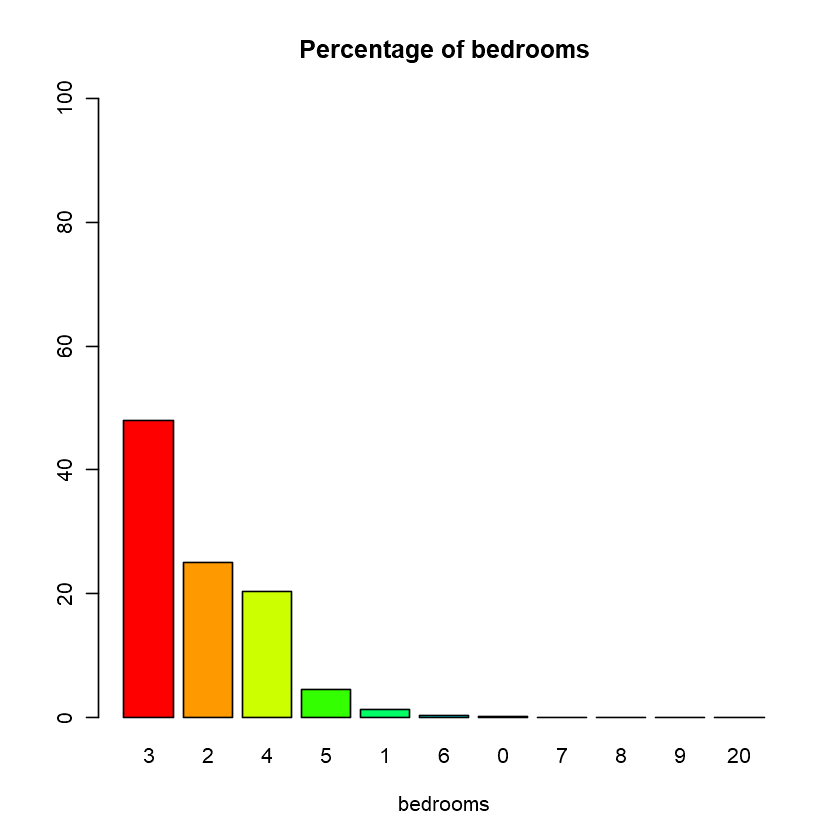

In [32]:
#= Bedrooms =#
table.Bedroom2<-table(refined.realestate$Bedroom2)
bedroompercent<-prop.table(sort(table.Bedroom2, decreasing = T))*100;bedroompercent
barplot(bedroompercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of bedrooms",xlab = "bedrooms")


          1           2           3           4           5           0 
55.92457421 35.27980535  7.60340633  0.76642336  0.20681265  0.14598540 
          6           7           8 
 0.04866180  0.01216545  0.01216545 

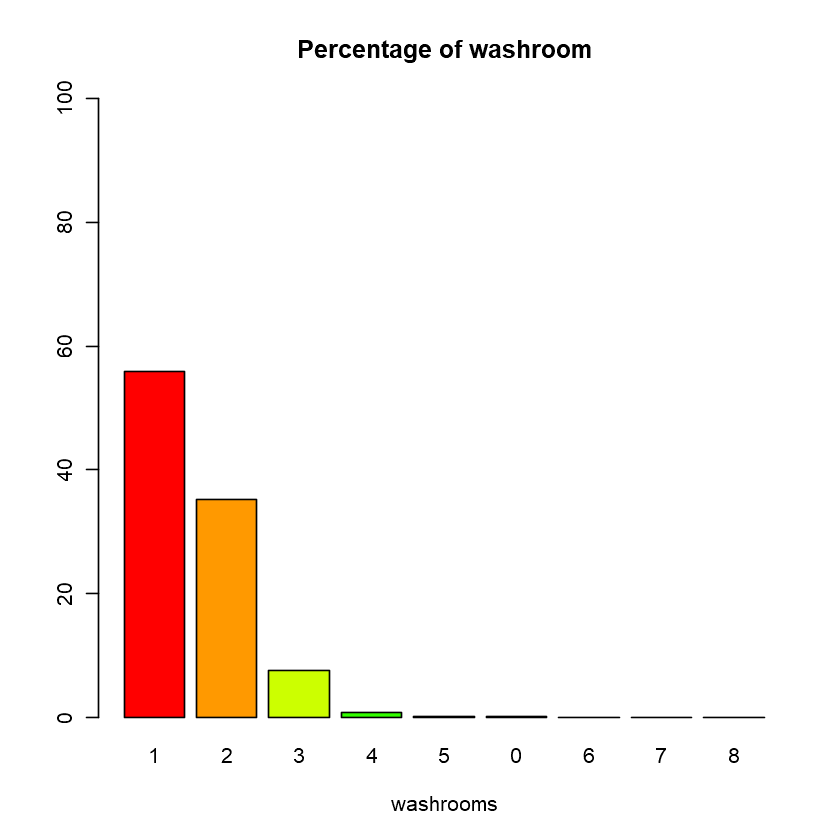

In [33]:
#= Bathroom =#
table.Bathroom<-table(refined.realestate$Bathroom)
washroompercent<-prop.table(sort(table.Bathroom, decreasing = T))*100;washroompercent
barplot(washroompercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of washroom",xlab = "washrooms")


         2          1          0          3          4          5          6 
47.4939173 35.8759124  7.5182482  4.8905109  3.4306569  0.3771290  0.2676399 
         7          8 
 0.0729927  0.0729927 

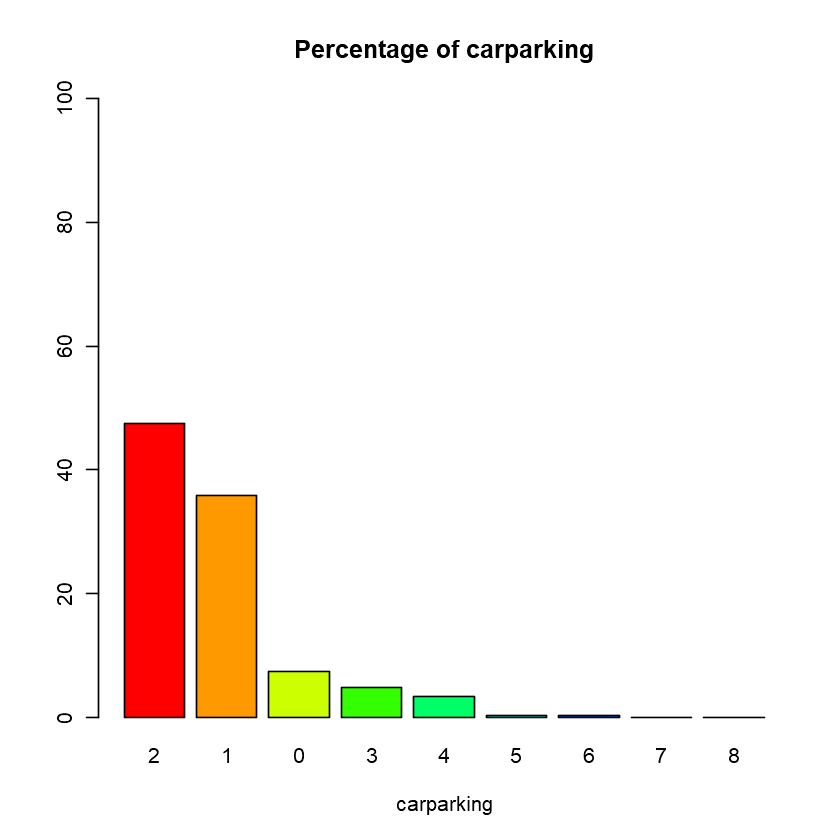

In [34]:
#= Car Parkings =#
table.carparking<-table(refined.realestate$Car)
carparkingpercent<-prop.table(sort(table.carparking, decreasing = T))*100;carparkingpercent
barplot(carparkingpercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of carparking",xlab = "carparking")



      far  very far    medium      near very near 
30.815085 24.209246 23.990268 16.046229  4.939173 

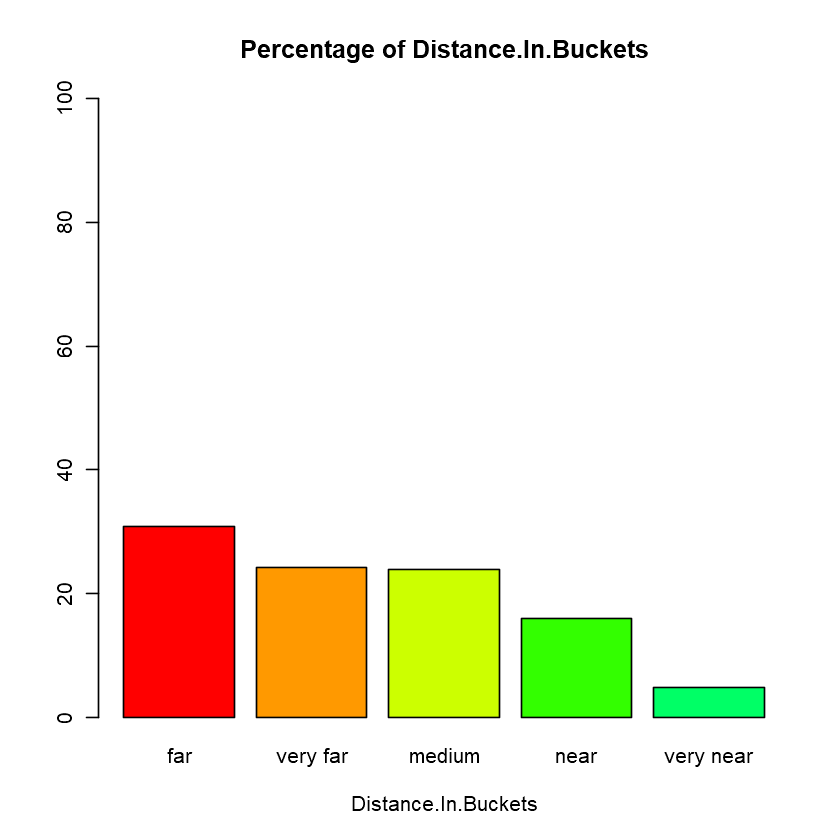

In [35]:
#= Distance in buckets =#
table.Distance.In.Buckets<-table(refined.realestate$Dist.bucket)
Distance.In.Bucketspercent<-prop.table(sort(table.Distance.In.Buckets, decreasing = T))*100;Distance.In.Bucketspercent
barplot(Distance.In.Bucketspercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of Distance.In.Buckets",xlab = "Distance.In.Buckets")



  8L- 16L     4L-8L   16L-25L      >25L       <4L 
49.695864 28.613139 15.206813  5.000000  1.484185 

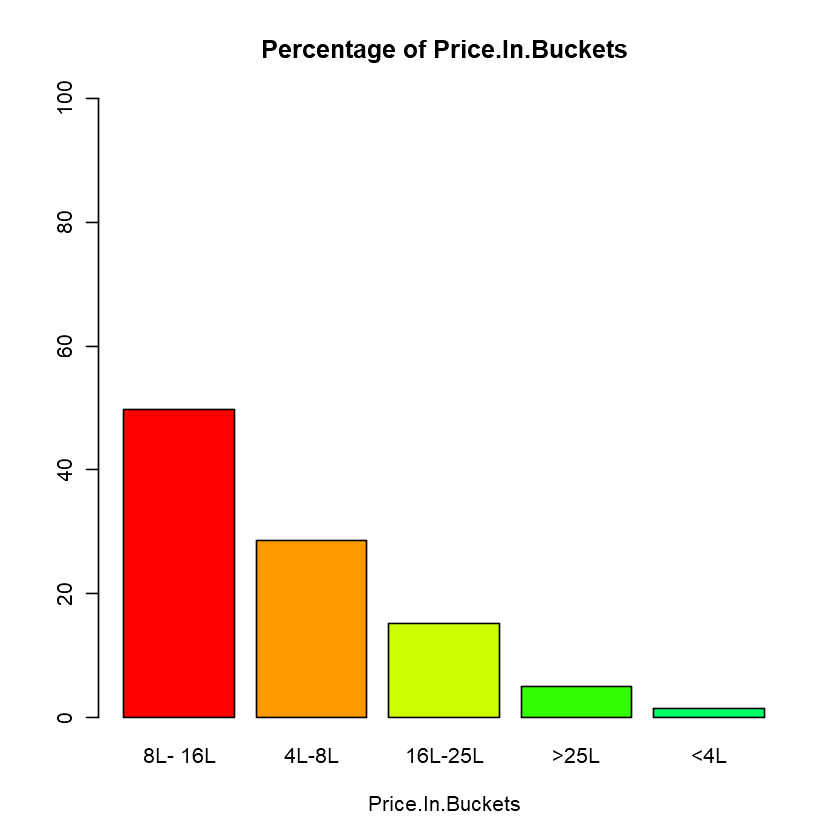

In [36]:
#= Price in buckets =#
table.Price.In.Buckets<-table(refined.realestate$Price.bucket)
Price.In.Bucketspercent<-prop.table(sort(table.Price.In.Buckets, decreasing = T))*100;Price.In.Bucketspercent
barplot(Price.In.Bucketspercent,ylim = c(0,100),col = rainbow(10),main = "Percentage of Price.In.Buckets",xlab = "Price.In.Buckets")



    Nov'16     Sep'16     May'16     Jun'16     May'17     Aug'16     Mar'17 
12.6763990 10.4136253 10.2676399  8.4671533  8.3333333  8.0656934  7.8588808 
    Apr'17     Dec'16     Oct'16     Feb'17     Jul'16     Apr'16     Feb'16 
 7.1532847  6.8978102  6.1800487  4.8296837  4.8053528  3.7104623  0.3163017 
    Jan'16     Mar'16     Jan'17     Jun'17 
 0.0243309  0.0000000  0.0000000  0.0000000 

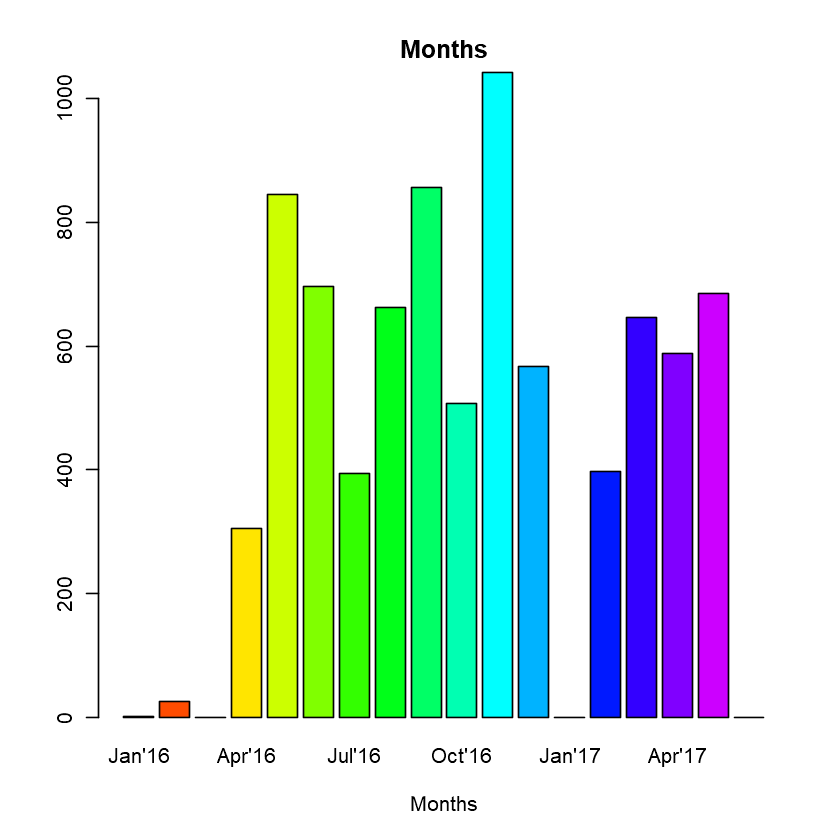

In [37]:
#= In Months =#
table.Months<-table(refined.realestate$Months)
Monthspercent<-prop.table(sort(table.Months, decreasing = T))*100;Monthspercent
barplot(table.Months,ylim = c(0,1000),col = rainbow(20),main = "Months",xlab = "Months")


,Price,Distance,Landsize,BuildingArea
Price,1.00000000,-0.218220467,0.013802765,0.31642075
Distance,-0.21822047,1.000000000,-0.005205102,0.07813262
Landsize,0.01380276,-0.005205102,1.000000000,0.01470247
BuildingArea,0.31642075,0.078132616,0.014702466,1.00000000


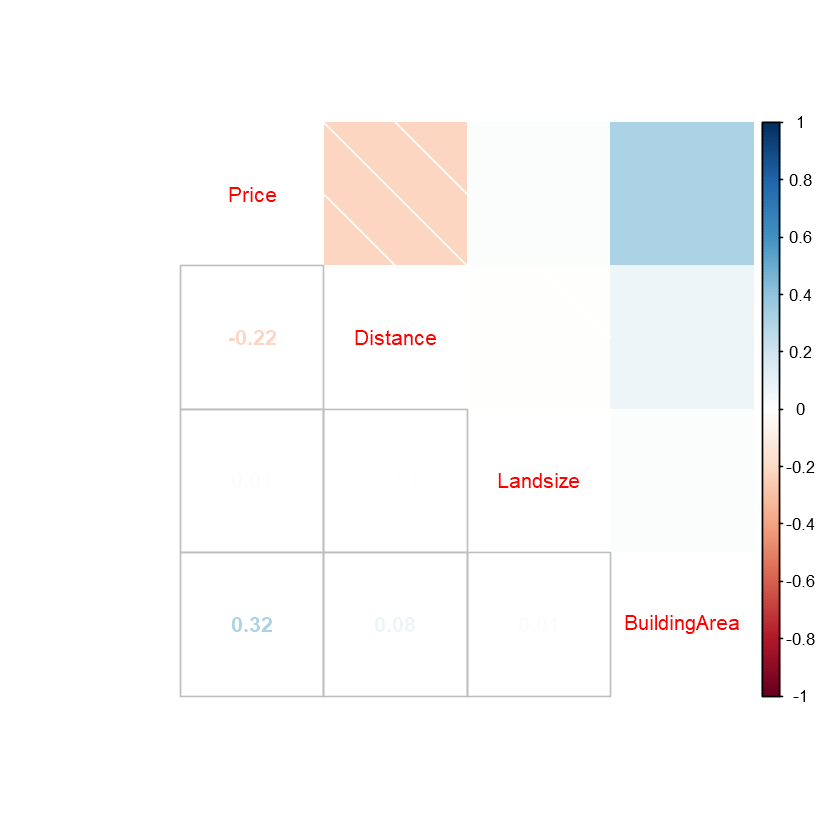

In [40]:
###=== Bivariate Analysis ===###
##== Correlation ==##
re.cor<-cor(re.analysis.cont)
re.cor
corrplot.mixed(re.cor,lower = "number",upper = "shade", bg = "black")


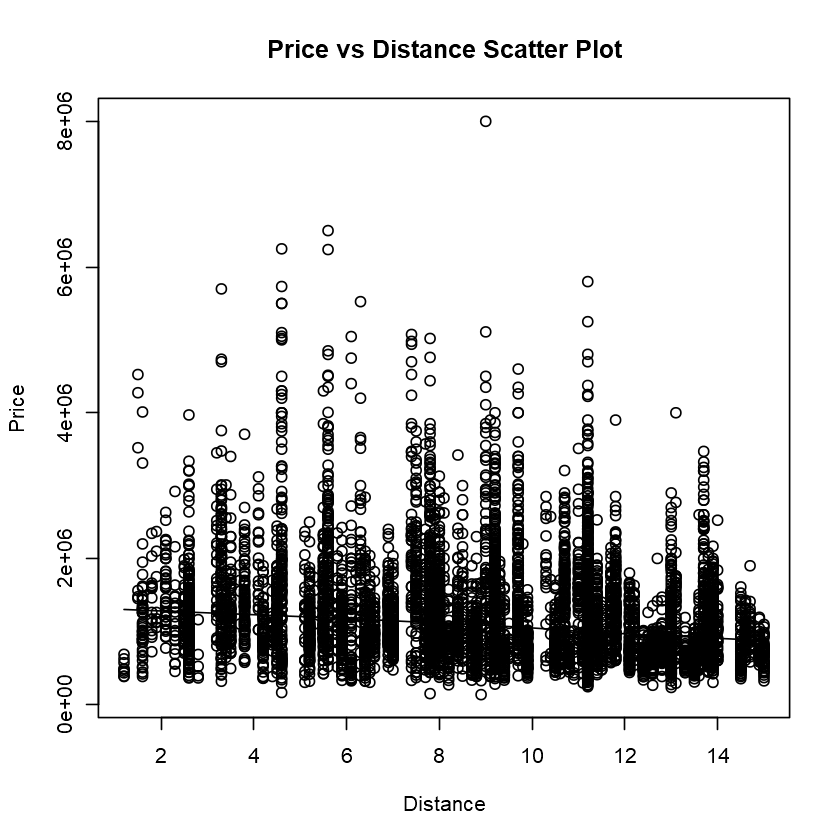

In [41]:
##== Scatter Plot b/w Distance and Price ==##
scatter.smooth(re.analysis$Distance,re.analysis$Price,xlab = "Distance",ylab = "Price",main = "Price vs Distance Scatter Plot") # Price vs Distance

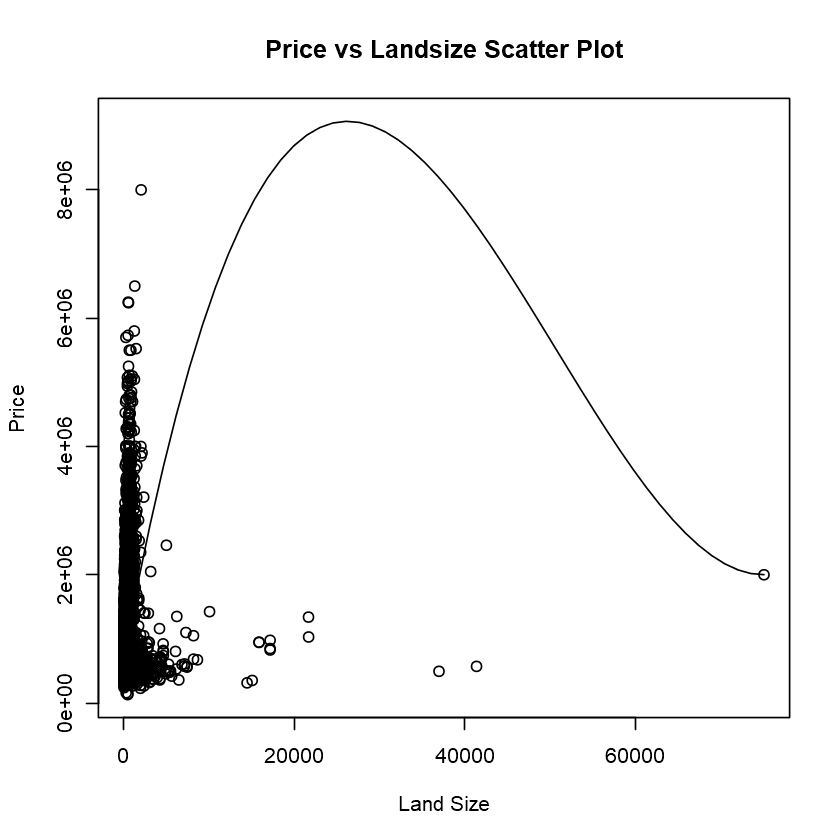

In [42]:
##== Scatter Plot b/w landsize and Price ==##

scatter.smooth(re.analysis$Landsize,re.analysis$Price,xlab = "Land Size",ylab = "Price",main = "Price vs Landsize Scatter Plot") #Price vs Landsize


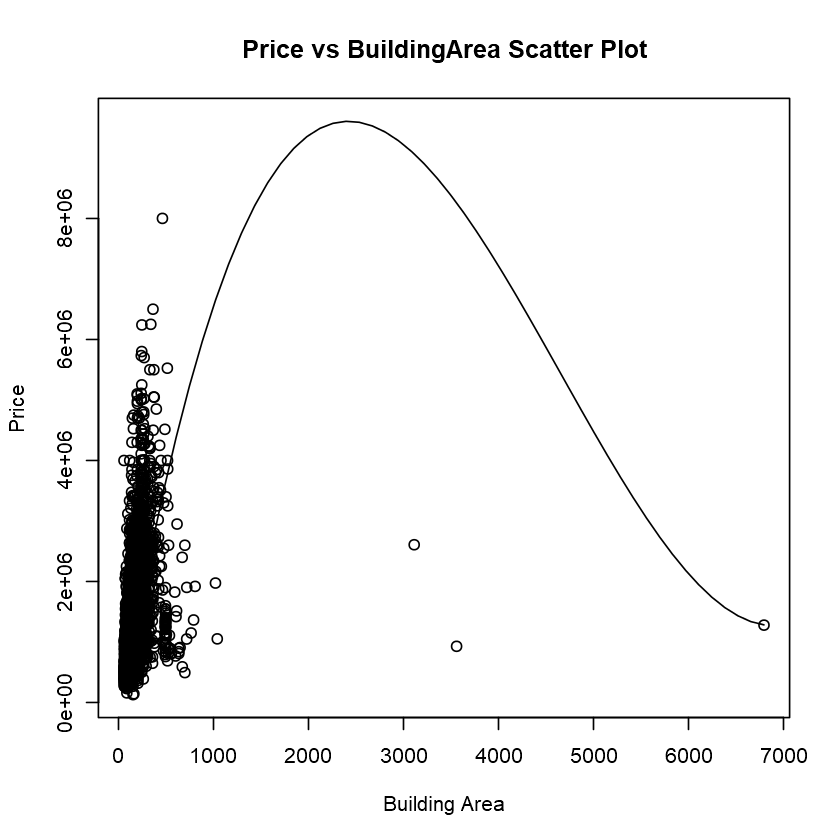

In [43]:
##== Scatter Plot b/w BuildingArea and Price ==##

scatter.smooth(re.analysis$BuildingArea,re.analysis$Price,xlab = "Building Area",ylab = "Price",main = "Price vs BuildingArea Scatter Plot") #Price vs BuildingArea

In [44]:
##== Comparing Price with other Significant attributes ==##
by(re.analysis$Price,re.analysis$Type, summary)
by(re.analysis$Price,re.analysis$Dist.bucket, summary)
by(re.analysis$Price,re.analysis$Months, summary)
by(re.analysis$Price,re.analysis$Method, summary)
by(re.analysis$Price,re.analysis$Rooms, summary)

re.analysis$Type: h
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 131000  835000 1135000 1310602 1590000 8000000 
------------------------------------------------------------ 
re.analysis$Type: t
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 300000  684000  860000  950163 1130000 3475000 
------------------------------------------------------------ 
re.analysis$Type: u
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 160000  490000  612250  649879  752000 3210000 

re.analysis$Dist.bucket: very near
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 360000  940250 1200000 1292193 1492500 4525000 
------------------------------------------------------------ 
re.analysis$Dist.bucket: near
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 160000  934250 1260000 1452151 1711000 6500000 
------------------------------------------------------------ 
re.analysis$Dist.bucket: medium
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 131000  821750 1055000 1265229 1500000 8000000 
------------------------------------------------------------ 
re.analysis$Dist.bucket: far
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 240000  727500 1000000 1224004 1591000 5800000 
------------------------------------------------------------ 
re.analysis$Dist.bucket: very far
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 230000  650250  830000  943963 1150000 4000000 

re.analysis$Months: Jan'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 813000  911000 1009000 1009000 1107000 1205000 
------------------------------------------------------------ 
re.analysis$Months: Feb'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 461000  775000  919000 1013375 1216875 1755000 
------------------------------------------------------------ 
re.analysis$Months: Mar'16
NULL
------------------------------------------------------------ 
re.analysis$Months: Apr'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 360000  720000  937500 1122288 1350000 4375000 
------------------------------------------------------------ 
re.analysis$Months: May'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 260000  730000  980500 1189354 1450000 5110000 
------------------------------------------------------------ 
re.analysis$Months: Jun'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 145000  716500  973000 1169146 1471250 5250000 
---------------------------------

re.analysis$Method: PI
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 131000  730000 1050000 1243711 1575000 5800000 
------------------------------------------------------------ 
re.analysis$Method: S
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 266000  770000 1030000 1210676 1455000 6500000 
------------------------------------------------------------ 
re.analysis$Method: SA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 330000  782500  941500 1216100 1388125 3225000 
------------------------------------------------------------ 
re.analysis$Method: SP
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 288000  662000  880000 1005174 1210000 4600000 
------------------------------------------------------------ 
re.analysis$Method: VB
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 160000  770000 1125000 1386232 1775000 8000000 

re.analysis$Rooms: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 160000  360000  428000  623469  681000 2605000 
------------------------------------------------------------ 
re.analysis$Rooms: 2
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 230000  600000  775500  854936 1014250 4800000 
------------------------------------------------------------ 
re.analysis$Rooms: 3
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 305000  765000  990000 1123894 1370000 6250000 
------------------------------------------------------------ 
re.analysis$Rooms: 4
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 131000 1019000 1420000 1592502 1928500 5733000 
------------------------------------------------------------ 
re.analysis$Rooms: 5
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 585000 1335500 1810000 2042740 2600000 8000000 
------------------------------------------------------------ 
re.analysis$Rooms: 6
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 725000 1413250 1880000 2

In [47]:
##== Comparing Distance with other Significant attributes ==##
by(re.analysis$Distance,re.analysis$Type, summary)
#by(re.analysis$Distance,re.analysis$Dist.bucket, summary)
by(re.analysis$Distance,re.analysis$Months, summary)
by(re.analysis$Distance,re.analysis$Method, summary)
by(re.analysis$Distance,re.analysis$Rooms, summary)

re.analysis$Type: h
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.500   6.600   9.200   9.215  11.800  15.000 
------------------------------------------------------------ 
re.analysis$Type: t
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.600   7.500   9.800   9.508  12.100  14.700 
------------------------------------------------------------ 
re.analysis$Type: u
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.200   6.100   9.300   9.037  11.400  14.900 

re.analysis$Months: Jan'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   11.2    11.2    11.2    11.2    11.2    11.2 
------------------------------------------------------------ 
re.analysis$Months: Feb'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.500   7.725   9.200   9.742  12.850  14.700 
------------------------------------------------------------ 
re.analysis$Months: Mar'16
NULL
------------------------------------------------------------ 
re.analysis$Months: Apr'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.600   6.500   9.200   8.984  11.400  14.900 
------------------------------------------------------------ 
re.analysis$Months: May'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.20    6.60    9.70    9.29   11.80   15.00 
------------------------------------------------------------ 
re.analysis$Months: Jun'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.500   7.000   9.400   9.419  12.100  15.000 
---------------------------------

re.analysis$Method: PI
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.200   6.750   9.200   9.321  11.800  15.000 
------------------------------------------------------------ 
re.analysis$Method: S
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.200   6.600   9.400   9.276  12.100  15.000 
------------------------------------------------------------ 
re.analysis$Method: SA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.30    7.85   10.75   10.29   13.60   14.60 
------------------------------------------------------------ 
re.analysis$Method: SP
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.500   6.900   9.200   9.166  11.400  15.000 
------------------------------------------------------------ 
re.analysis$Method: VB
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.20    6.10    9.10    8.58   11.20   15.00 

re.analysis$Rooms: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.200   3.500   6.100   6.175   8.400  13.900 
------------------------------------------------------------ 
re.analysis$Rooms: 2
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.200   5.200   8.000   8.075  11.200  14.900 
------------------------------------------------------------ 
re.analysis$Rooms: 3
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.500   7.000   9.700   9.505  12.400  15.000 
------------------------------------------------------------ 
re.analysis$Rooms: 4
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.500   7.800  10.400   9.884  12.600  15.000 
------------------------------------------------------------ 
re.analysis$Rooms: 5
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.600   7.900   9.700   9.817  11.700  15.000 
------------------------------------------------------------ 
re.analysis$Rooms: 6
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.800   7.500   9.200  

In [48]:
##== Comparing Landsize with other Significant attributes ==##
by(re.analysis$Landsize,re.analysis$Type, summary)
by(re.analysis$Landsize,re.analysis$Dist.bucket, summary)
by(re.analysis$Landsize,re.analysis$Months, summary)
by(re.analysis$Landsize,re.analysis$Method, summary)
by(re.analysis$Landsize,re.analysis$Rooms, summary)


re.analysis$Type: h
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   327.5   559.0   542.0   661.0 75100.0 
------------------------------------------------------------ 
re.analysis$Type: t
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   73.0   156.0   230.0   343.9   318.0 15900.0 
------------------------------------------------------------ 
re.analysis$Type: u
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   172.2   290.0   989.3   973.8 37000.0 

re.analysis$Dist.bucket: very near
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   134.2   194.0   611.4   298.8 15900.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: near
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   71.0   189.5   308.0   566.5   521.5 21715.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: medium
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   71.0   275.0   431.0   533.9   608.0 37000.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: far
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   341.0   593.0   621.1   704.0 75100.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: very far
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   428.1   597.8   560.4   672.0  5289.0 

re.analysis$Months: Jan'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  108.0   203.5   299.0   299.0   394.5   490.0 
------------------------------------------------------------ 
re.analysis$Months: Feb'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   77.0   201.8   403.9   433.5   647.4   970.0 
------------------------------------------------------------ 
re.analysis$Months: Mar'16
NULL
------------------------------------------------------------ 
re.analysis$Months: Apr'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   240.0   502.0   616.1   632.0 41400.0 
------------------------------------------------------------ 
re.analysis$Months: May'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   77.0   276.8   535.0   537.1   656.0  7170.0 
------------------------------------------------------------ 
re.analysis$Months: Jun'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   72.0   265.0   533.0   531.8   664.8  7458.0 
---------------------------------

re.analysis$Method: PI
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   71.0   304.5   564.0   602.7   690.5 14500.0 
------------------------------------------------------------ 
re.analysis$Method: S
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   266.0   513.0   555.1   650.0 41400.0 
------------------------------------------------------------ 
re.analysis$Method: SA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  134.0   294.0   550.0   503.8   670.5   934.0 
------------------------------------------------------------ 
re.analysis$Method: SP
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   251.0   462.0   540.9   631.7  5661.0 
------------------------------------------------------------ 
re.analysis$Method: VB
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   77.0   268.0   557.0   773.8   710.0 75100.0 

re.analysis$Rooms: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     70     290     706    1297    1547   14500 
------------------------------------------------------------ 
re.analysis$Rooms: 2
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   70.0   160.0   267.5   588.4   588.2 37000.0 
------------------------------------------------------------ 
re.analysis$Rooms: 3
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     70     281     485     531     627   75100 
------------------------------------------------------------ 
re.analysis$Rooms: 4
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   95.0   458.8   603.0   587.3   697.0  3747.0 
------------------------------------------------------------ 
re.analysis$Rooms: 5
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   98.0   589.5   661.0   695.4   759.5  2079.0 
------------------------------------------------------------ 
re.analysis$Rooms: 6
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  350.0   656.3   729.3  

In [49]:
##== Comparing BuildingArea with other Significant attributes ==##
by(re.analysis$BuildingArea,re.analysis$Type, summary)
by(re.analysis$BuildingArea,re.analysis$Dist.bucket, summary)
by(re.analysis$BuildingArea,re.analysis$Months, summary)
by(re.analysis$BuildingArea,re.analysis$Method, summary)
by(re.analysis$BuildingArea,re.analysis$Rooms, summary)

re.analysis$Type: h
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   135.0   152.8   173.5   198.0  6791.0 
------------------------------------------------------------ 
re.analysis$Type: t
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   118.0   139.4   153.5   173.3  3558.0 
------------------------------------------------------------ 
re.analysis$Type: u
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  60.00   81.24   91.00   93.85  101.83  475.00 

re.analysis$Dist.bucket: very near
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0    95.0   118.1   121.1   131.1   291.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: near
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   110.0   143.3   152.2   163.5  3558.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: medium
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   120.0   144.6   160.8   194.4  3112.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: far
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   120.0   154.0   180.2   217.2  6791.0 
------------------------------------------------------------ 
re.analysis$Dist.bucket: very far
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   68.0   130.0   146.9   158.4   183.7   792.0 

re.analysis$Months: Jan'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  87.44  121.87  156.29  156.29  190.71  225.14 
------------------------------------------------------------ 
re.analysis$Months: Feb'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   79.0   115.8   137.4   135.4   151.6   202.9 
------------------------------------------------------------ 
re.analysis$Months: Mar'16
NULL
------------------------------------------------------------ 
re.analysis$Months: Apr'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   65.0   118.1   144.6   158.8   182.5   496.5 
------------------------------------------------------------ 
re.analysis$Months: May'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   62.0   118.1   150.1   165.9   195.2   673.0 
------------------------------------------------------------ 
re.analysis$Months: Jun'16
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  64.25  120.00  151.50  170.13  196.93 1041.00 
---------------------------------

re.analysis$Method: PI
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   63.0   127.0   152.8   175.6   203.0   766.0 
------------------------------------------------------------ 
re.analysis$Method: S
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   118.1   144.6   160.8   185.2  6791.0 
------------------------------------------------------------ 
re.analysis$Method: SA
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  93.17  131.09  166.72  171.17  202.29  267.62 
------------------------------------------------------------ 
re.analysis$Method: SP
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   109.0   141.0   149.0   174.1   636.4 
------------------------------------------------------------ 
re.analysis$Method: VB
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   130.4   168.3   180.2   221.0   700.0 

re.analysis$Rooms: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  60.00   80.00   93.17  106.37  132.00  262.96 
------------------------------------------------------------ 
re.analysis$Rooms: 2
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0    88.0   106.6   122.0   143.3  3558.0 
------------------------------------------------------------ 
re.analysis$Rooms: 3
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   64.0   125.0   144.5   155.4   174.9  1041.0 
------------------------------------------------------------ 
re.analysis$Rooms: 4
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   154.0   191.4   204.5   226.2  6791.0 
------------------------------------------------------------ 
re.analysis$Rooms: 5
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   177.2   228.1   252.0   275.5  3112.0 
------------------------------------------------------------ 
re.analysis$Rooms: 6
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  141.7   193.3   226.6  

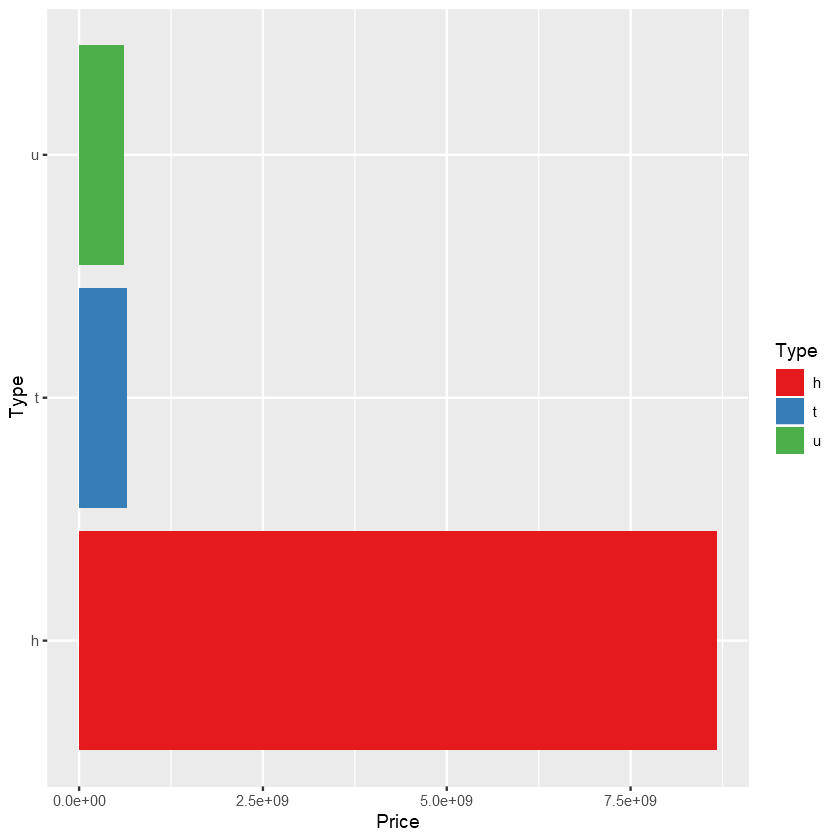

In [50]:
##== Barplot ==##
# == Barplot b/w Type and Price == #
ggplot(re.analysis, aes(x=Type, y=Price, fill=Type)) + geom_bar(stat="identity") + labs(x="Type", y="Price") + coord_flip() + scale_fill_brewer(palette = "Set1") #Price vs Type

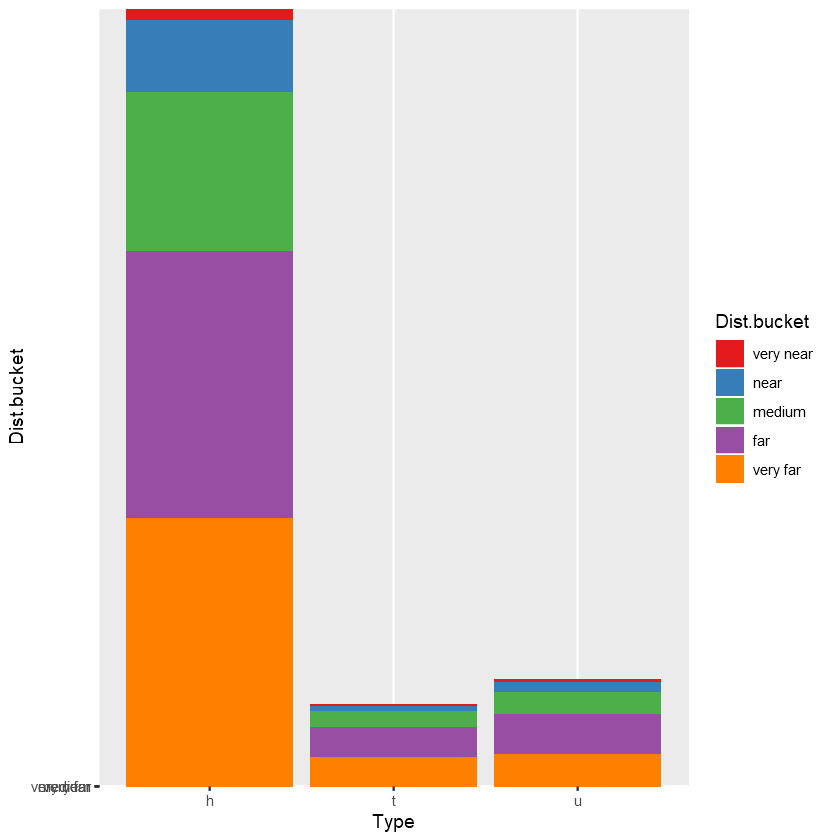

In [51]:
# == Barplot b/w Type and Dist.bucket == #

ggplot(re.analysis, aes(y=Dist.bucket, x=Type, fill=Dist.bucket)) + geom_bar(stat="identity") + labs(y="Dist.bucket", x="Type") + scale_fill_brewer(palette = "Set1") #Type vs Dist.bucket


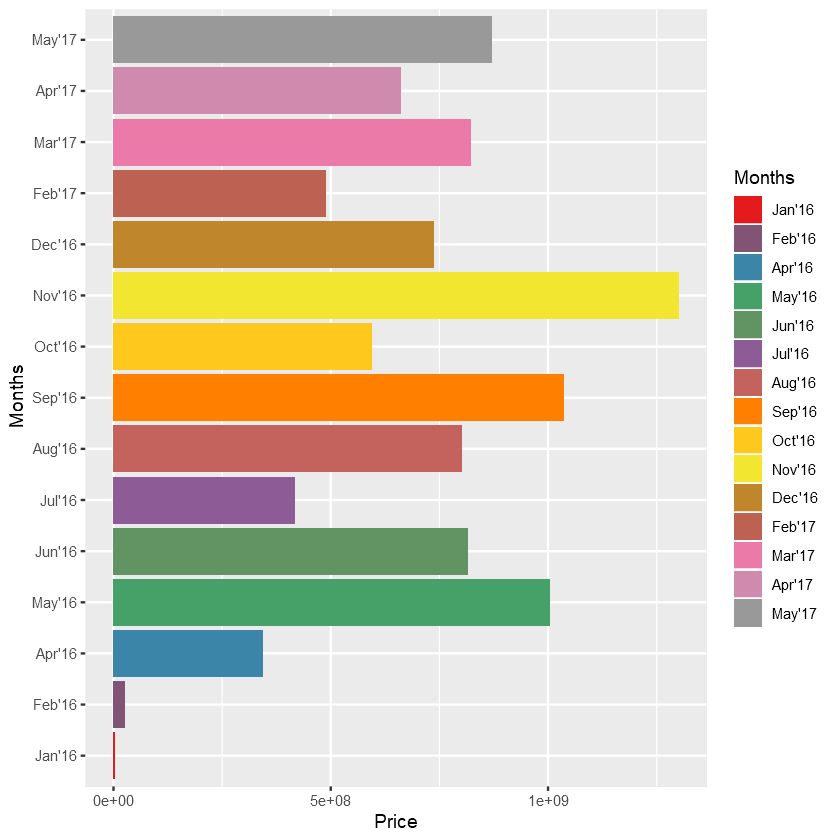

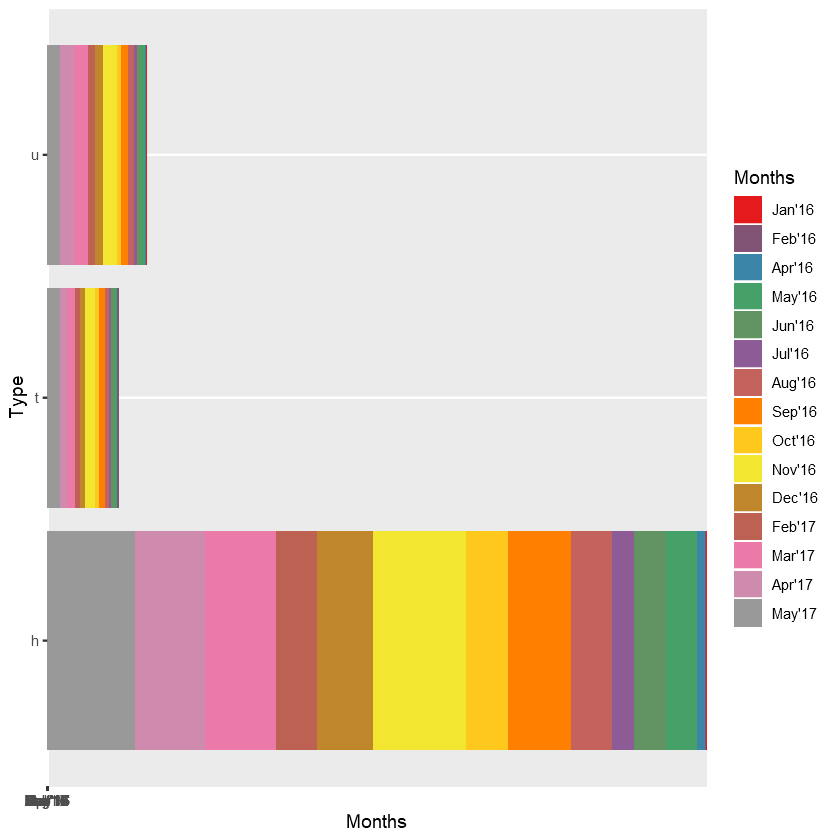

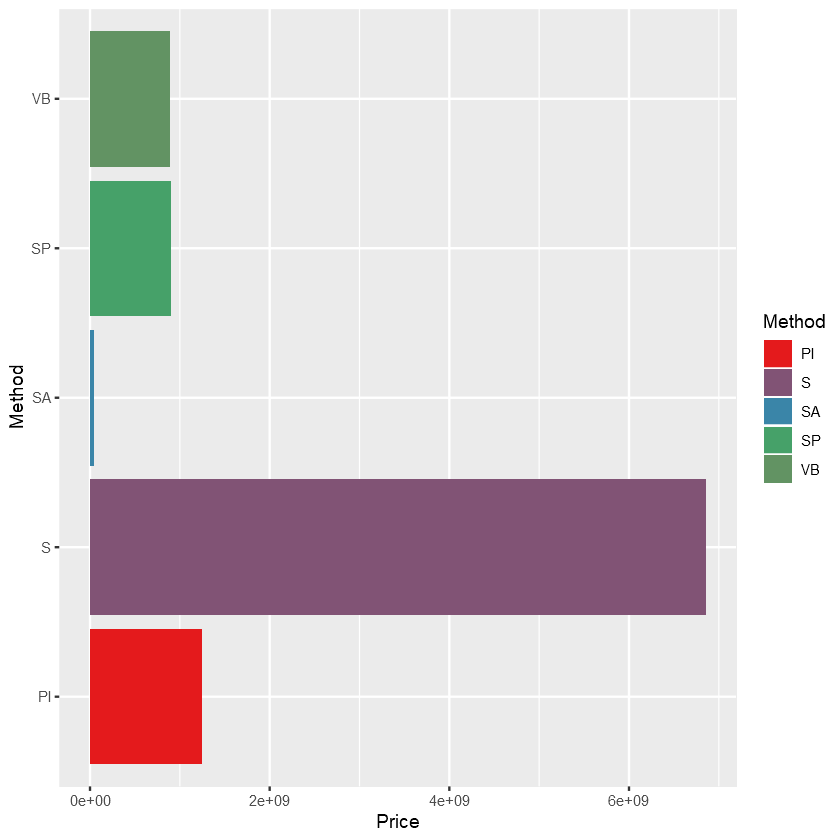

In [56]:
colourCount = length(unique(refined.realestate$Months))
getPalette = colorRampPalette(brewer.pal(9, "Set1"))
ggplot(re.analysis, aes(x=Months, y=Price,fill=Months)) + geom_bar(stat="identity") + labs(x="Months", y="Price") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Price vs Months

ggplot(re.analysis, aes(y=Months, x=Type,fill=Months)) + geom_bar(stat="identity") + labs(y="Months", x="Type") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Type vs Months

ggplot(re.analysis, aes(x=Method, y=Price,fill=Method)) + geom_bar(stat="identity") + labs(y="Price", x="Method") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Price vs Method


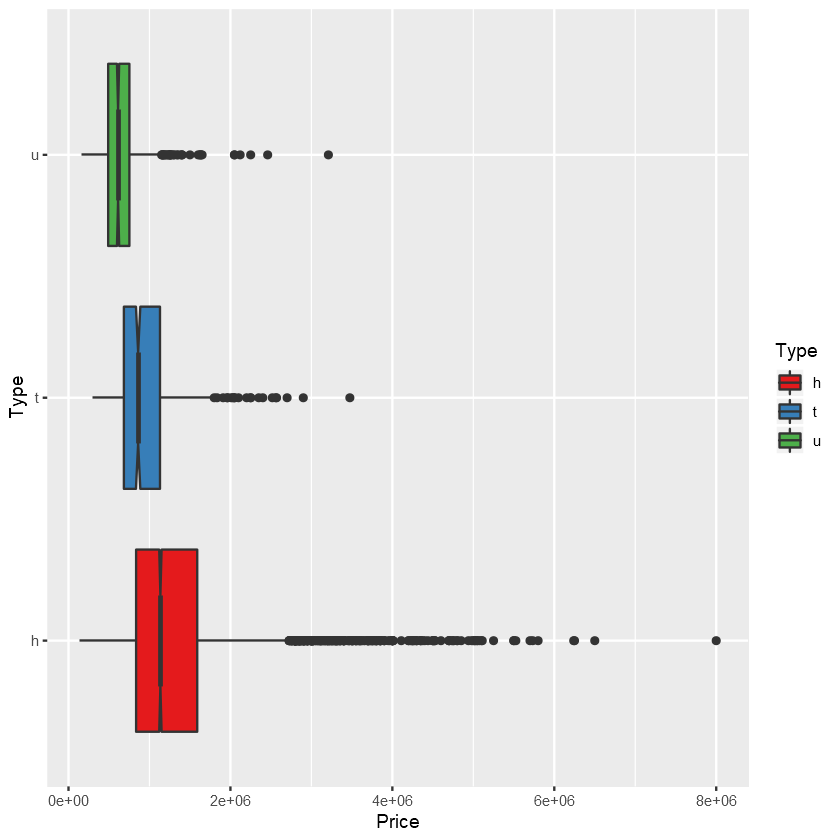

In [57]:
##== Boxplot ==##
ggplot(re.analysis, aes(x=Type, y=Price, fill=Type)) + geom_boxplot(notch = T) + labs(x="Type", y="Price")+ coord_flip() + scale_fill_brewer(palette = "Set1") #Price vs Type


notch went outside hinges. Try setting notch=FALSE.


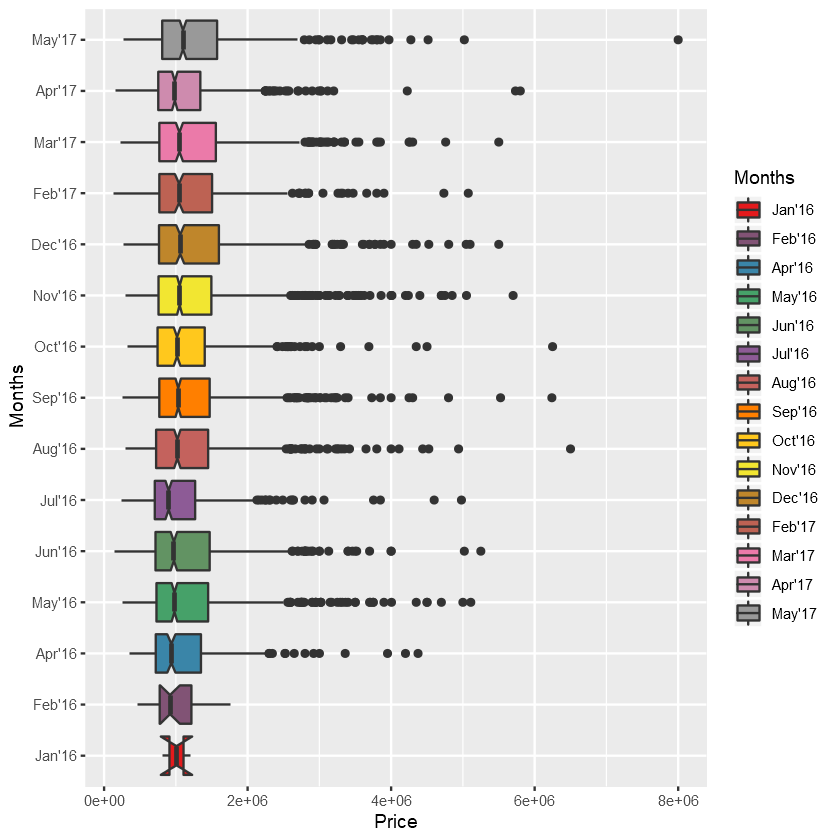

In [58]:
colourCount = length(unique(refined.realestate$Months))
getPalette = colorRampPalette(brewer.pal(9, "Set1"))
ggplot(re.analysis, aes(x=Months, y=Price,fill=Months)) + geom_boxplot(notch = T)  + labs(x="Months", y="Price") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Price vs Months


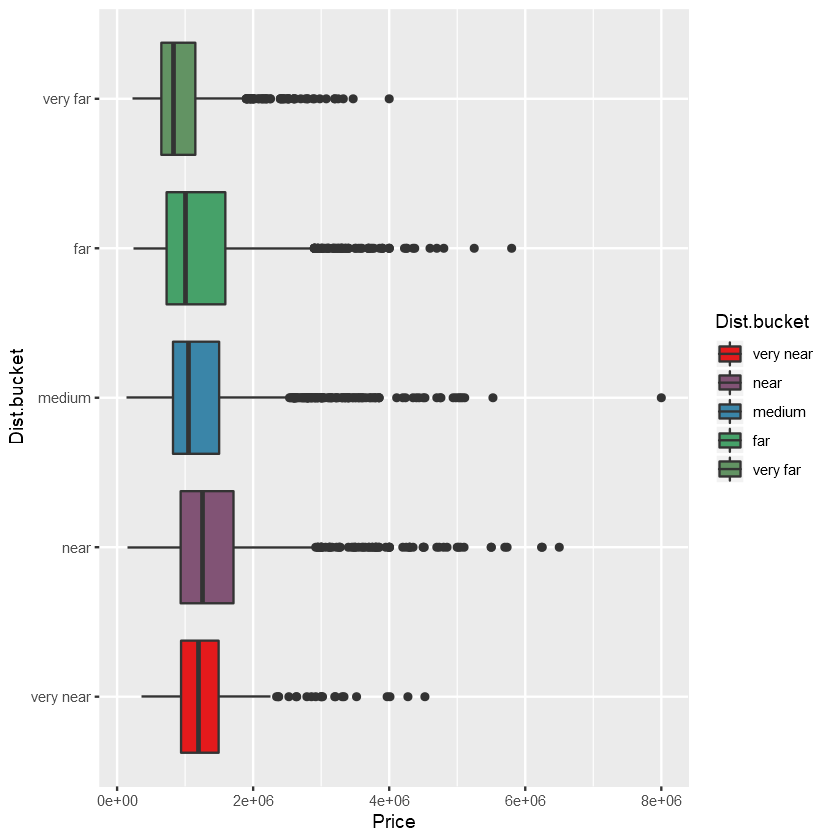

In [59]:
ggplot(re.analysis, aes(x=Dist.bucket, y=Price,fill=Dist.bucket)) + geom_boxplot(notch = F) + labs(y="Price", x="Dist.bucket") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Price vs Distance Bucket


notch went outside hinges. Try setting notch=FALSE.


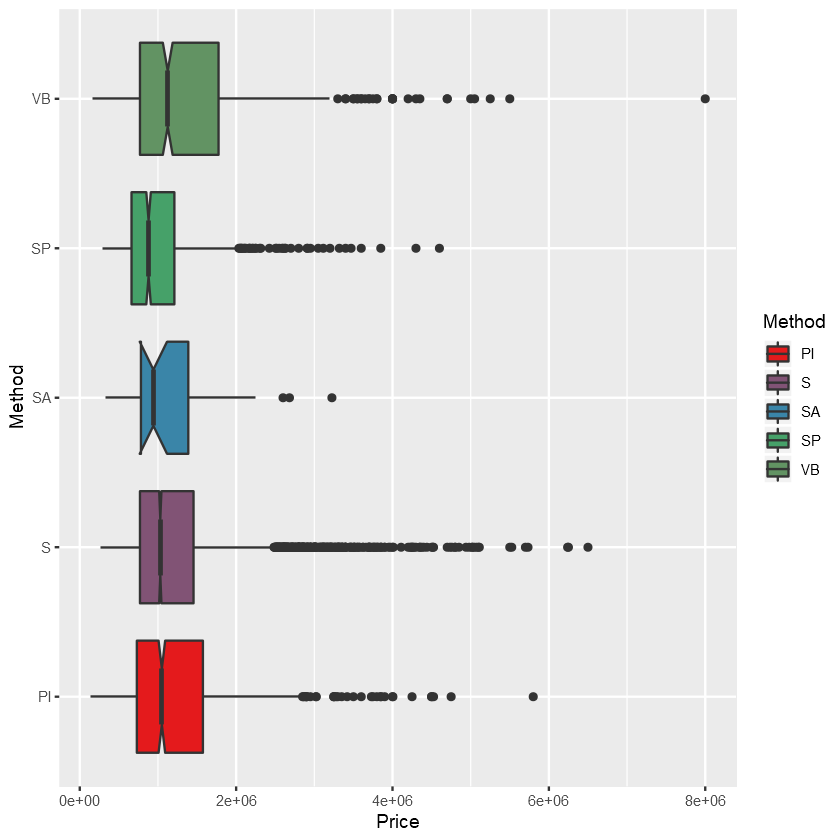

In [60]:
ggplot(re.analysis, aes(x=Method, y=Price,fill=Method)) + geom_boxplot(notch = T) + labs(y="Price", x="Method") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Price vs Method


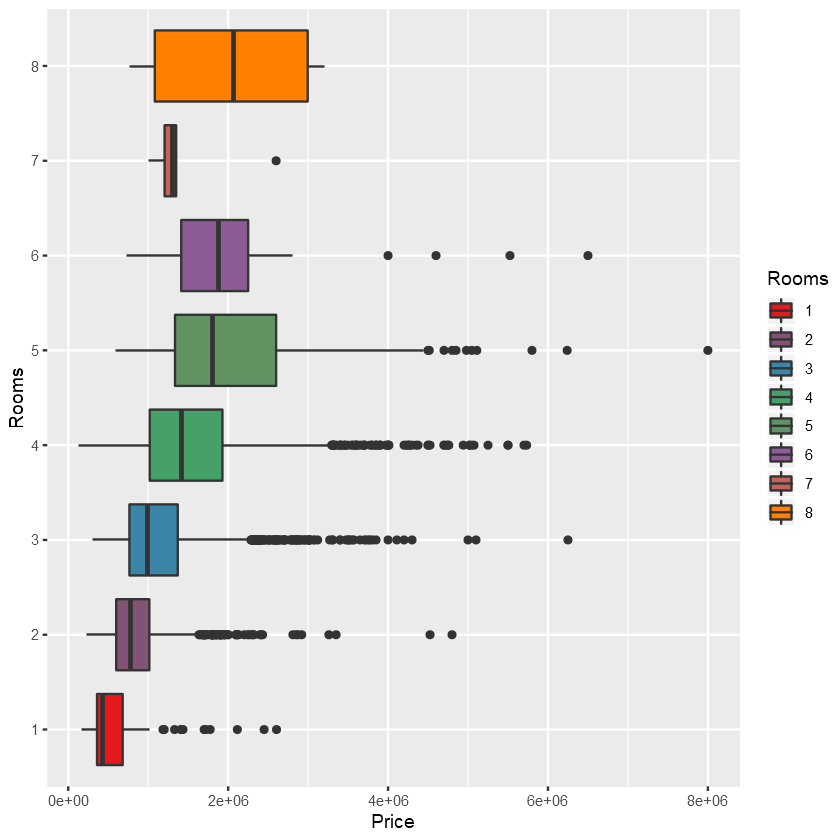

In [61]:
ggplot(re.analysis, aes(x=Rooms, y=Price,fill=Rooms)) + geom_boxplot(notch = F) + labs(y="Price", x="Rooms") + coord_flip() + scale_fill_manual(values = getPalette(colourCount)) #Price vs Rooms


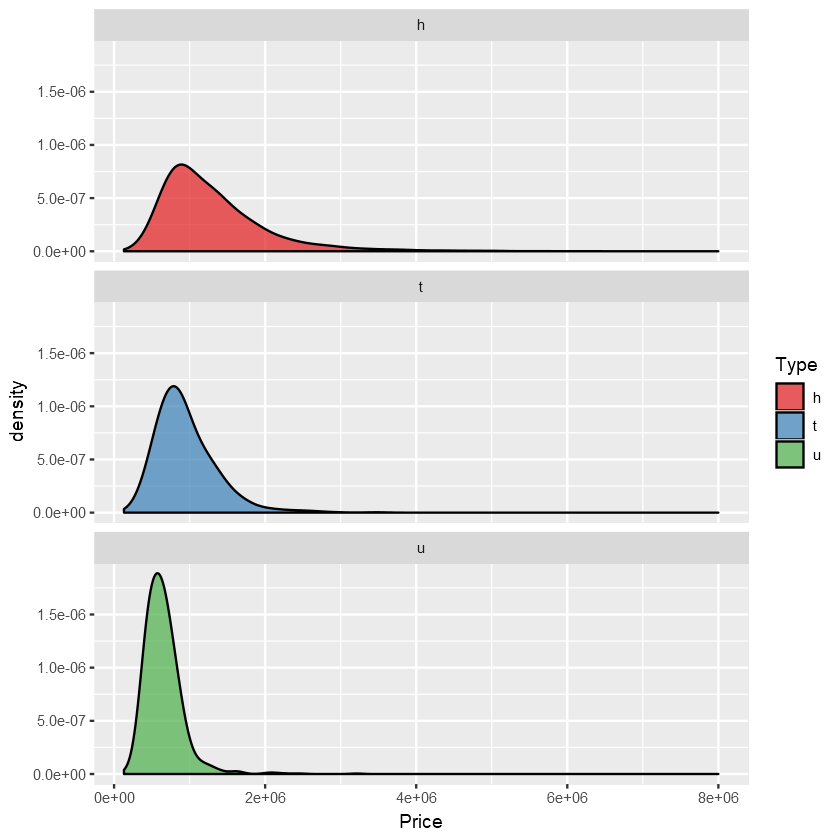

In [62]:
##== Density Plots ==##
#= Price vs Type=#
ggplot() + geom_density(data=refined.realestate, aes(x=Price, group=Type, fill=Type),alpha=0.7, adjust=2) + labs(x="Price")+ scale_fill_brewer(palette = "Set1") + facet_wrap(~ Type,nrow = 4) #Price vs Type


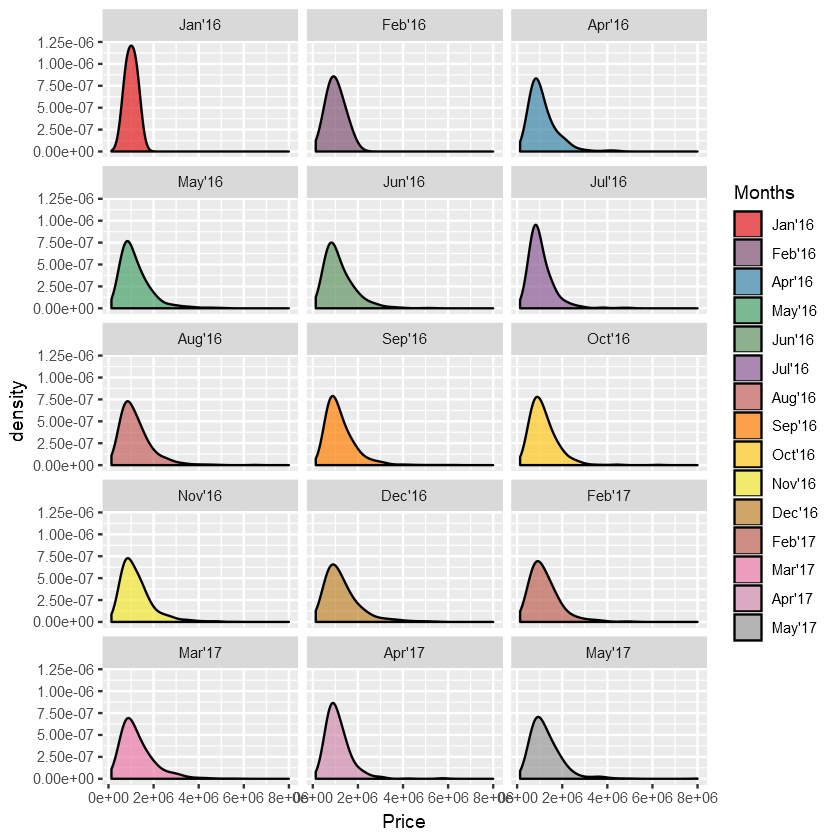

In [64]:
#== Price vs Months ==#
colourCount = length(unique(refined.realestate$Months))
getPalette = colorRampPalette(brewer.pal(9, "Set1"))
ggplot() + geom_density(data=refined.realestate, aes(x=Price, group=Months, fill=Months),alpha=0.7, adjust=2)  + labs(x="Price") +  scale_fill_manual(values = getPalette(colourCount)) + facet_wrap(~ Months,nrow = 6) #Price vs Months

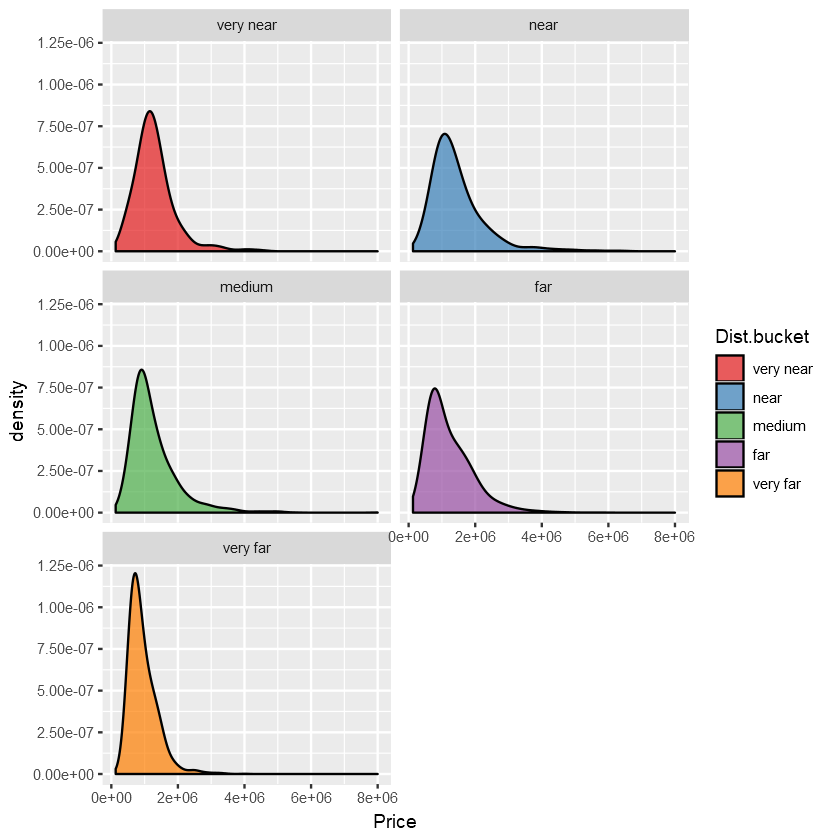

In [65]:
#== Price vs Dist.bucket ==#
ggplot() + geom_density(data=refined.realestate, aes(x=Price, group=Dist.bucket, fill=Dist.bucket),alpha=0.7, adjust=2) + labs(x="Price") +  scale_fill_brewer(palette = "Set1") + facet_wrap(~ Dist.bucket,nrow = 4)#Price vs Distance


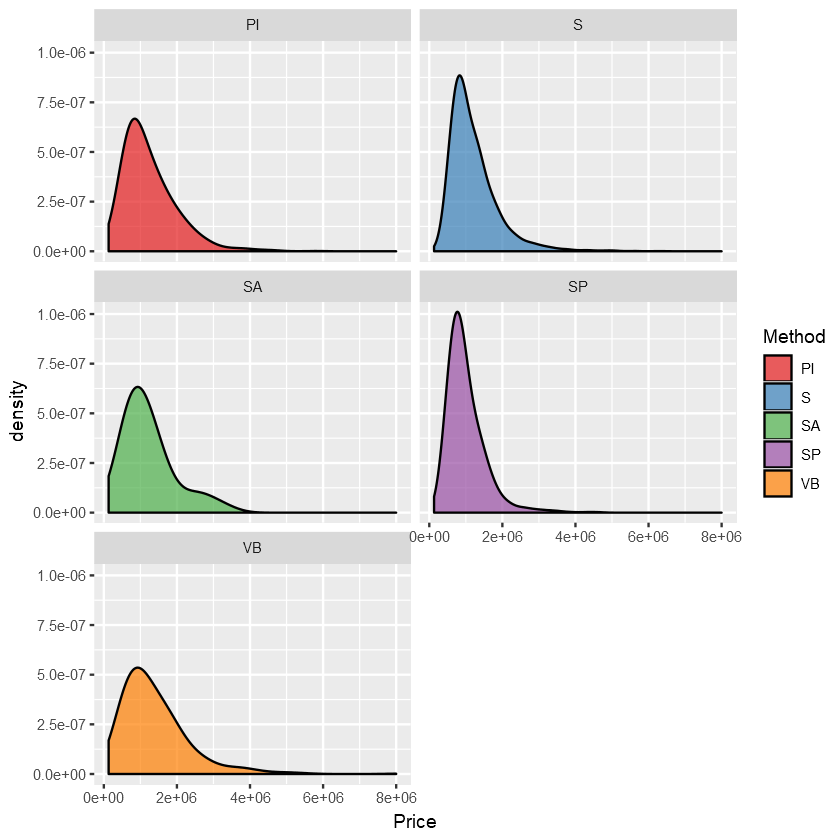

In [66]:
#== Price vs Method ==#

ggplot() + geom_density(data=refined.realestate, aes(x=Price, group=Method, fill=Method),alpha=0.7, adjust=2) + labs(x="Price") +  scale_fill_brewer(palette = "Set1") + facet_wrap(~ Method,nrow = 4) #Price vs Method


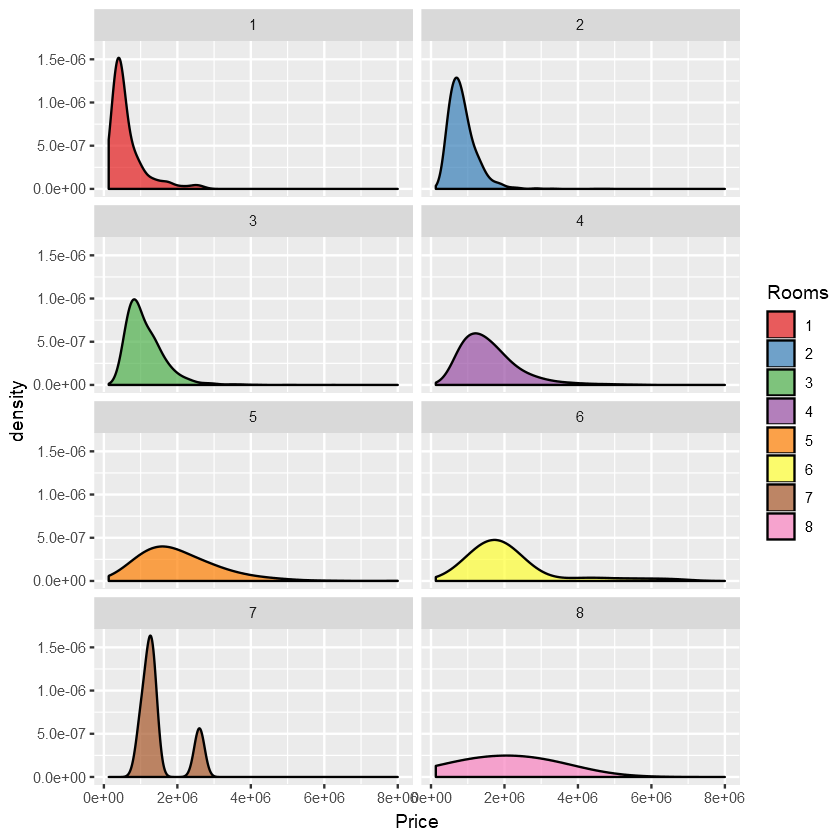

In [67]:
#== Price vs Rooms ==#

ggplot() + geom_density(data=refined.realestate, aes(x=Price, group=Rooms, fill=Rooms),alpha=0.7, adjust=2) + labs(x="Price") +  scale_fill_brewer(palette = "Set1") + facet_wrap(~ Rooms,nrow = 4) #Price vs Rooms


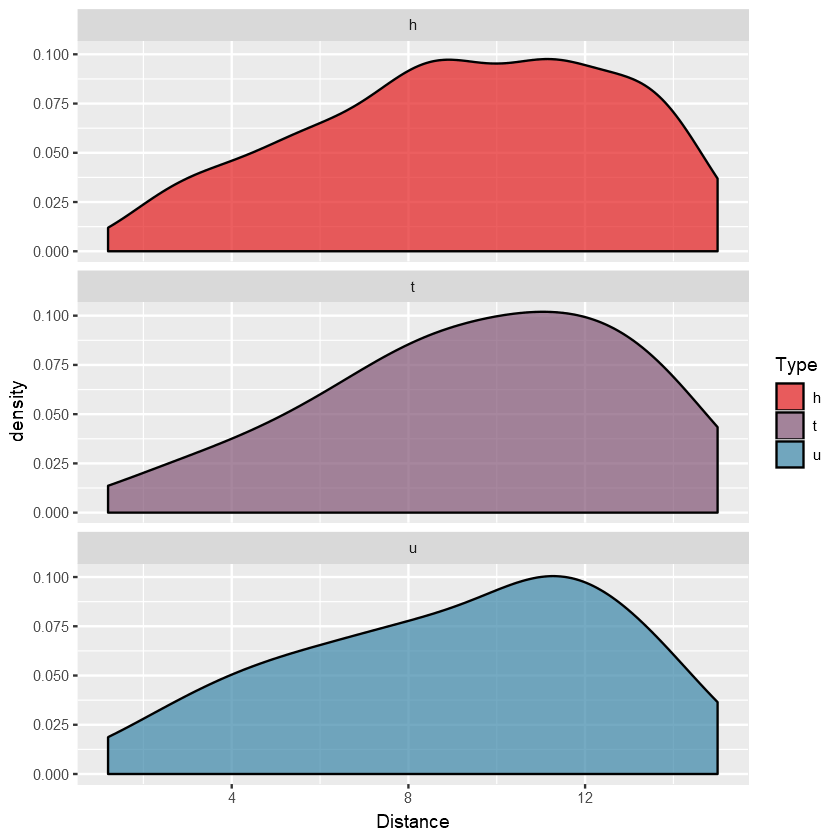

In [68]:
#= Distance vs Type=#

ggplot() +   geom_density(data=refined.realestate, aes(x=Distance, group=Type, fill=Type),alpha=0.7, adjust=2) + labs( x="Distance")  + scale_fill_manual(values = getPalette(colourCount)) + facet_wrap(~ Type,nrow = 4) #Distance vs Type

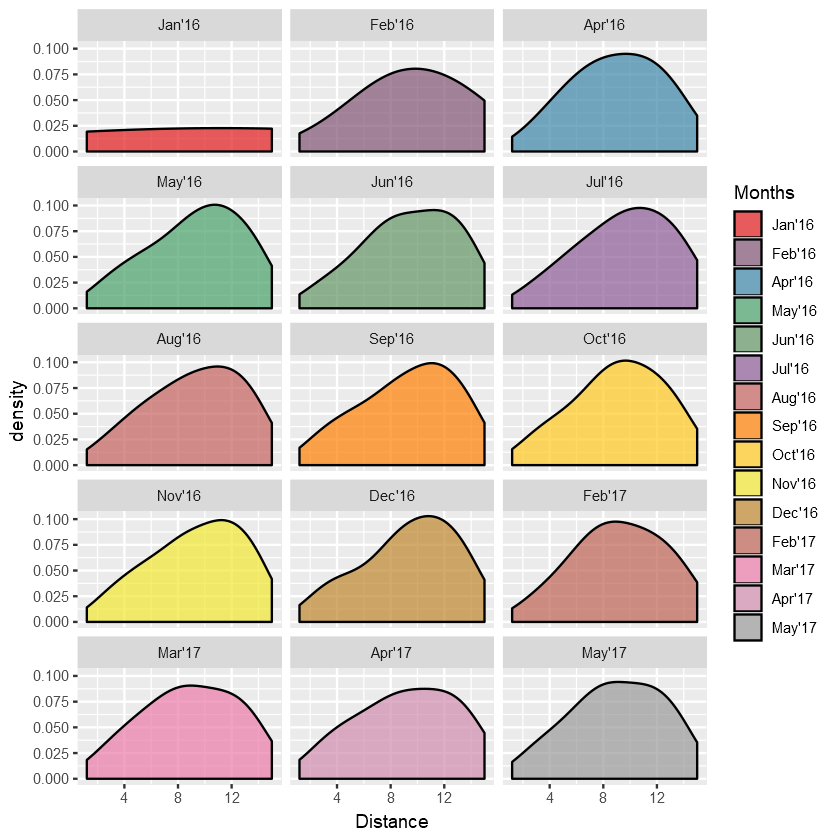

In [69]:
#= Distance vs Months=#
ggplot() +   geom_density(data=refined.realestate, aes(x=Distance, group=Months, fill=Months),alpha=0.7, adjust=2) + labs( x="Distance")  + scale_fill_manual(values = getPalette(colourCount)) + facet_wrap(~ Months,nrow = 7) #Distance vs Months


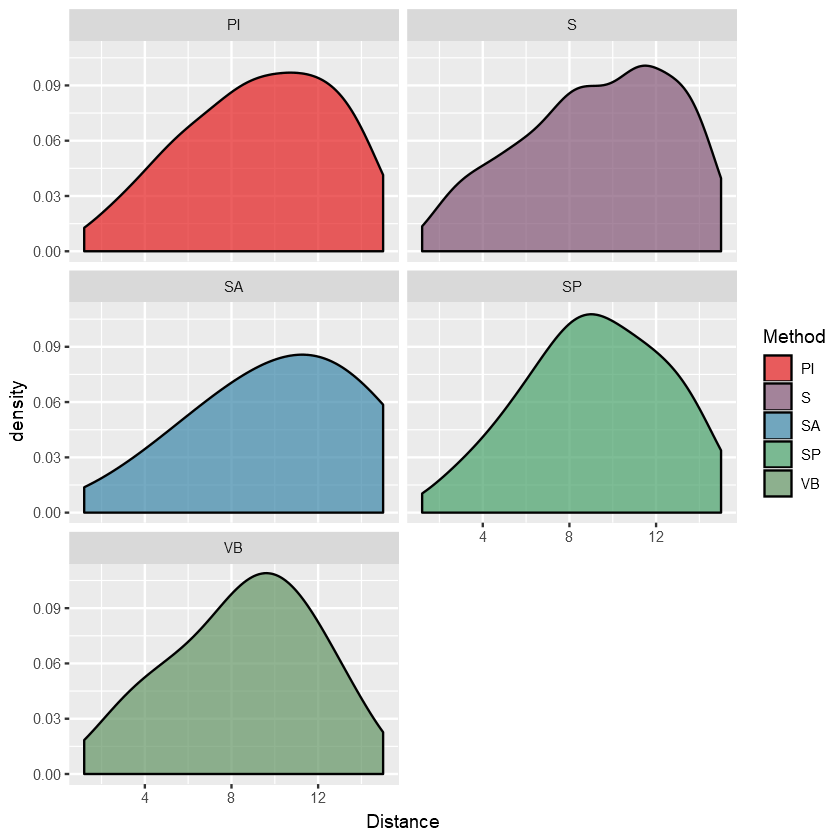

In [70]:
#= Distance vs Method=#
ggplot() +   geom_density(data=refined.realestate, aes(x=Distance, group=Method, fill=Method),alpha=0.7, adjust=2) + labs( x="Distance")  + scale_fill_manual(values = getPalette(colourCount)) + facet_wrap(~ Method,nrow = 4) #Distance vs Method


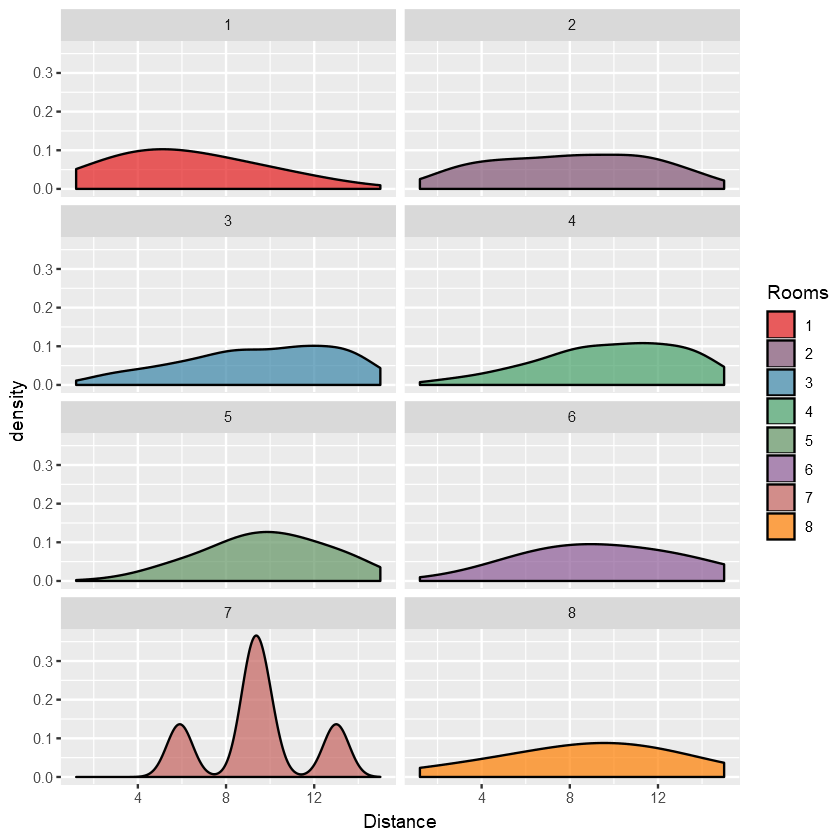

In [71]:
#= Distance vs Rooms=#
ggplot() +   geom_density(data=refined.realestate, aes(x=Distance, group=Rooms, fill=Rooms),alpha=0.7, adjust=2) + labs( x="Distance")  + scale_fill_manual(values = getPalette(colourCount)) + facet_wrap(~ Rooms,nrow = 4) #Distance vs Rooms


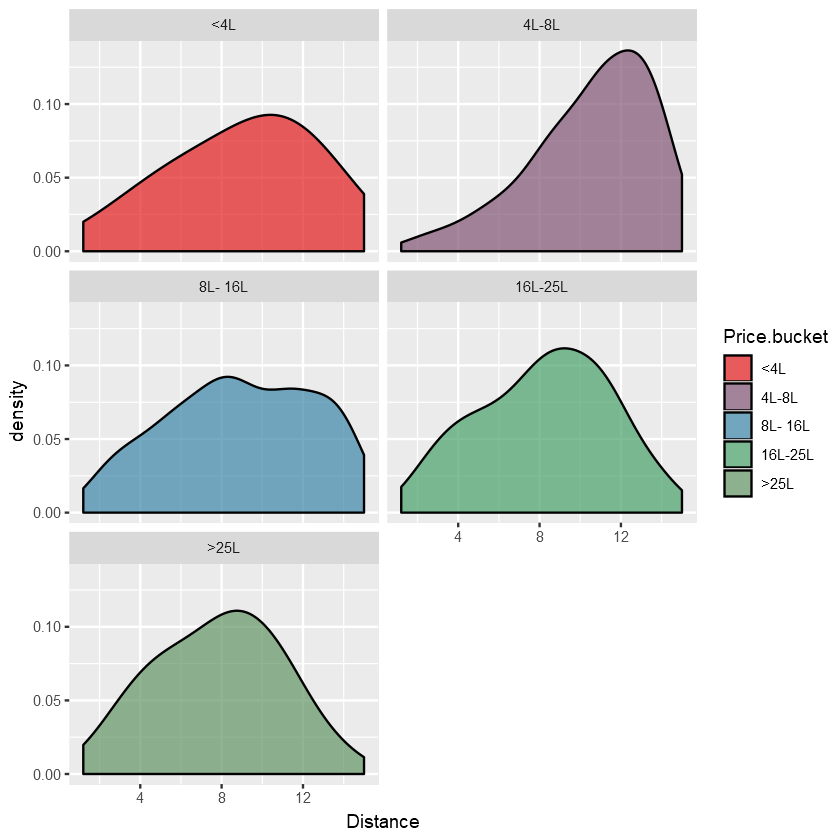

In [72]:
#= Distance vs Price.bucket=#
ggplot() +   geom_density(data=refined.realestate, aes(x=Distance, group=Price.bucket, fill=Price.bucket),alpha=0.7, adjust=2) + labs( x="Distance")  + scale_fill_manual(values = getPalette(colourCount)) + facet_wrap(~ Price.bucket,nrow = 4) #Distance vs Price Bucket


            Type
Price.bucket    h    t    u
     <4L       28    5   89
     4L-8L   1419  268  665
     8L- 16L 3555  365  165
     16L-25L 1205   35   10
     >25L     404    6    1

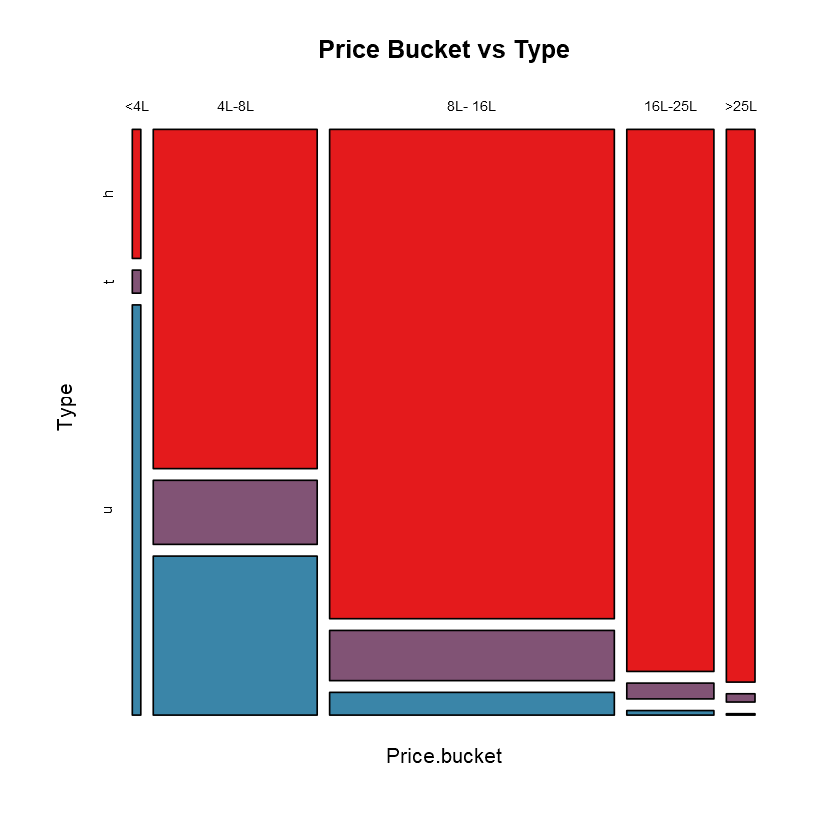

In [73]:
##== Xtabs ==##

#= Price vs Price.bucket+Type =#
xtabs(~Price.bucket+Type, re.analysis)
plot(xtabs(~Price.bucket+Type, re.analysis), main="Price Bucket vs Type", col=getPalette(colourCount))


, , Type = h

            Dist.bucket
Price.bucket very near near medium far very far
     <4L             0    1      4  10       13
     4L-8L          10   47    190 502      670
     8L- 16L       227  660    965 899      804
     16L-25L        60  267    308 466      104
     >25L           17  112    120 133       22

, , Type = t

            Dist.bucket
Price.bucket very near near medium far very far
     <4L             0    0      0   2        3
     4L-8L           2   20     61 105       80
     8L- 16L        29   52     90 100       94
     16L-25L         1    9     10  13        2
     >25L            0    2      0   4        0

, , Type = u

            Dist.bucket
Price.bucket very near near medium far very far
     <4L             8   15     25  33        8
     4L-8L          43   97    169 196      160
     8L- 16L         8   32     27  68       30
     16L-25L         0    5      3   2        0
     >25L            1    0      0   0        0


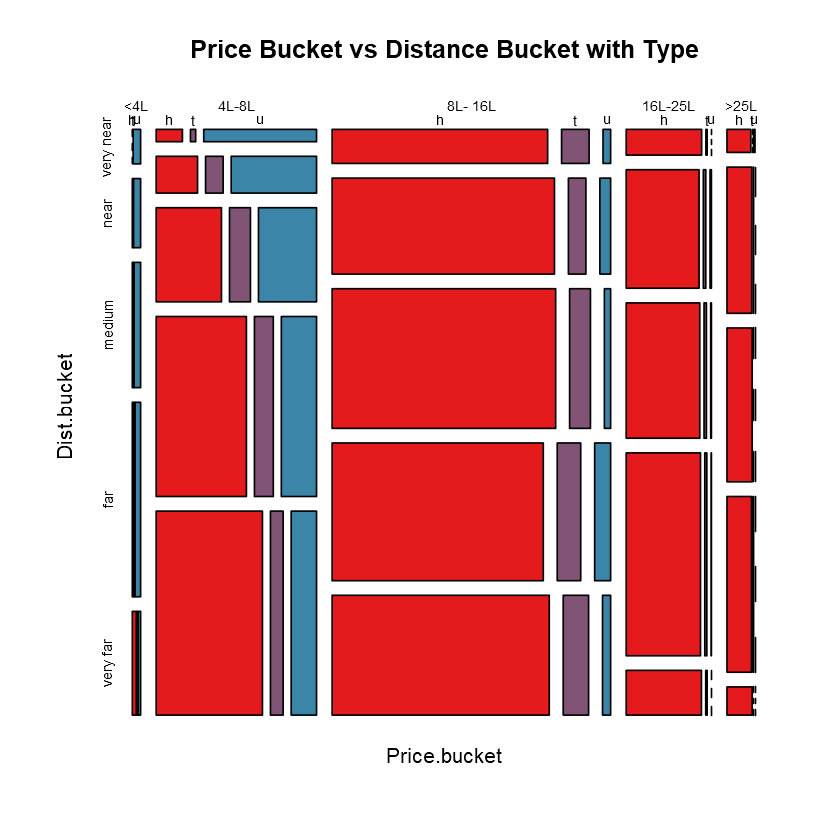

In [74]:
#= Price vs Price.bucket+Dist.bucket+Typee =#
xtabs(~Price.bucket+Dist.bucket+Type, re.analysis)
plot(xtabs(~Price.bucket+Dist.bucket+Type, re.analysis), main="Price Bucket vs Distance Bucket with Type", col=getPalette(colourCount))


, , Type = h

            Months
Price.bucket Jan'16 Feb'16 Mar'16 Apr'16 May'16 Jun'16 Jul'16 Aug'16 Sep'16
     <4L          0      0      0      1      9      6      1      1      2
     4L-8L        0      4      0     71    168    150     83    112    152
     8L- 16L      1     14      0    140    362    284    186    288    383
     16L-25L      0      2      0     40    119    104     38     96    132
     >25L         0      0      0     10     42     31     10     38     39
            Months
Price.bucket Oct'16 Nov'16 Dec'16 Jan'17 Feb'17 Mar'17 Apr'17 May'17 Jun'17
     <4L          3      0      0      0      2      0      1      2      0
     4L-8L       88    173    103      0     58     91     85     81      0
     8L- 16L    237    446    225      0    170    251    282    286      0
     16L-25L     74    149     90      0     60    107     67    127      0
     >25L        17     66     41      0     19     45     14     32      0

, , Type = t

            Months
Pr

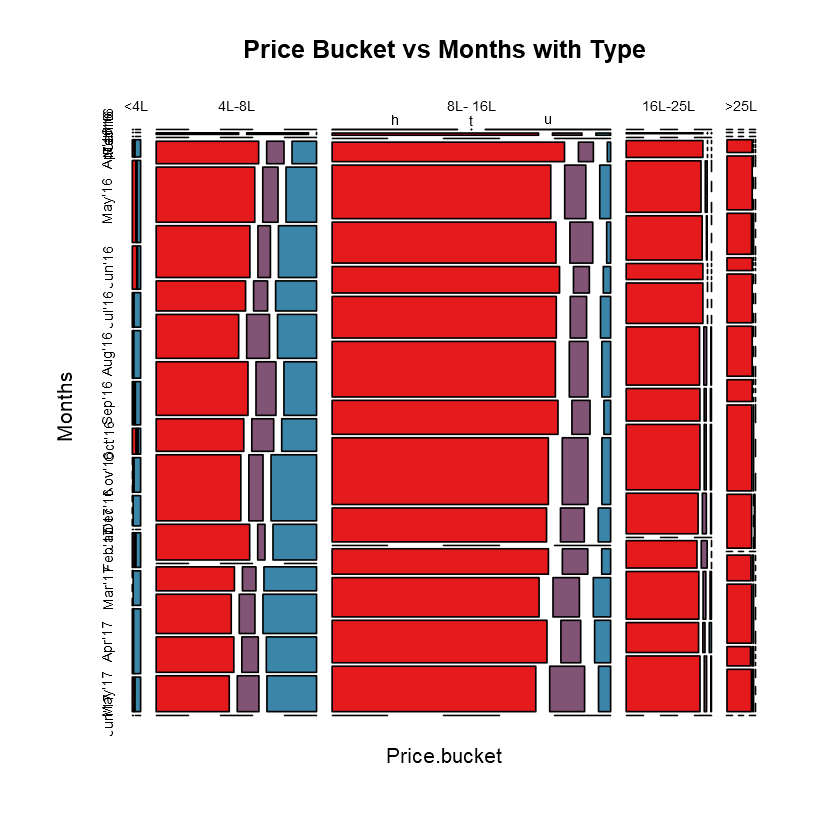

In [75]:
#= Price vs Price.bucket+Months+Type =#
xtabs(~Price.bucket+Months+Type, re.analysis)
plot(xtabs(~Price.bucket+Months+Type, re.analysis), main="Price Bucket vs Months with Type", col=getPalette(colourCount))


, , Type = h

            Method
Price.bucket   PI    S   SA   SP   VB
     <4L        9   12    0    4    3
     4L-8L    169  963    5  208   74
     8L- 16L  383 2545   14  388  225
     16L-25L  172  837    3   64  129
     >25L      60  262    3   21   58

, , Type = t

            Method
Price.bucket   PI    S   SA   SP   VB
     <4L        3    1    0    0    1
     4L-8L     40  154    1   43   30
     8L- 16L   51  237    0   40   37
     16L-25L    5   24    0    2    4
     >25L       1    2    0    1    2

, , Type = u

            Method
Price.bucket   PI    S   SA   SP   VB
     <4L       25   28    1   19   16
     4L-8L     71  446    1   94   53
     8L- 16L    9  138    2    9    7
     16L-25L    1    7    0    0    2
     >25L       0    1    0    0    0


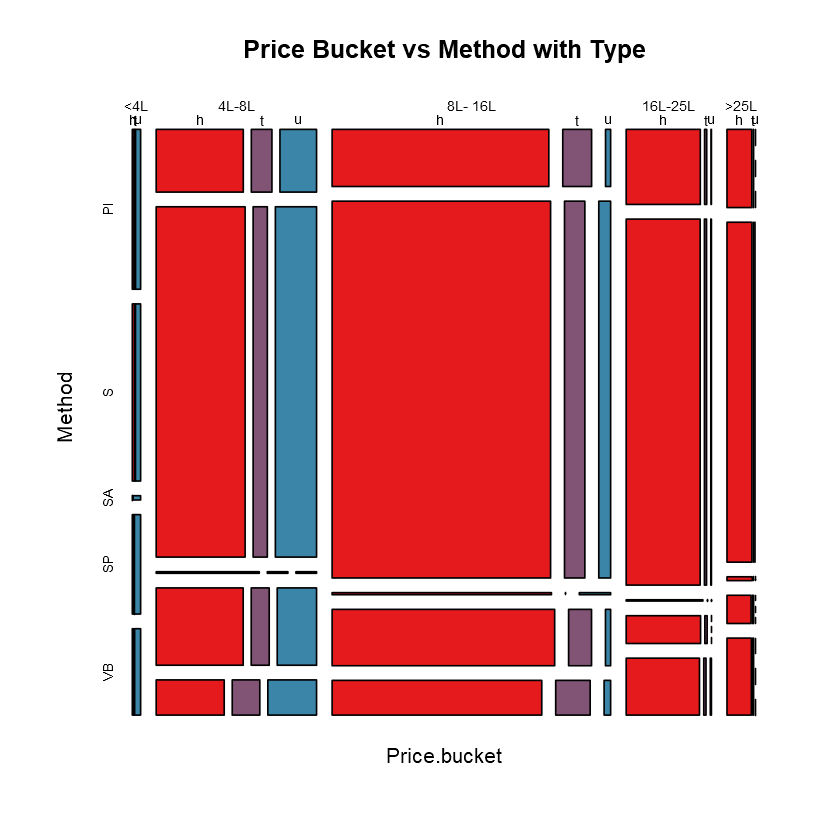

In [76]:
#= Price vs Price.bucket+Method+Type =#
xtabs(~Price.bucket+Method+Type, re.analysis)
plot(xtabs(~Price.bucket+Method+Type, re.analysis), main="Price Bucket vs Method with Type", col=getPalette(colourCount))


, , Type = h

            Bedroom2
Price.bucket    0    1    2    3    4    5    6    7    8    9   20
     <4L        0    4   10   13    1    0    0    0    0    0    0
     4L-8L      3   10  366  858  163   15    1    0    1    2    0
     8L- 16L    3   22  756 1876  751  131   11    4    1    0    0
     16L-25L    2    7   89  492  473  125   14    1    1    0    1
     >25L       0    1   11   78  202  104    6    0    1    1    0

, , Type = t

            Bedroom2
Price.bucket    0    1    2    3    4    5    6    7    8    9   20
     <4L        0    0    4    1    0    0    0    0    0    0    0
     4L-8L      0    2  106  151    8    1    0    0    0    0    0
     8L- 16L    1    2   54  248   58    2    0    0    0    0    0
     16L-25L    0    0    1   26    8    0    0    0    0    0    0
     >25L       0    0    0    3    3    0    0    0    0    0    0

, , Type = u

            Bedroom2
Price.bucket    0    1    2    3    4    5    6    7    8    9   20
     <4L 

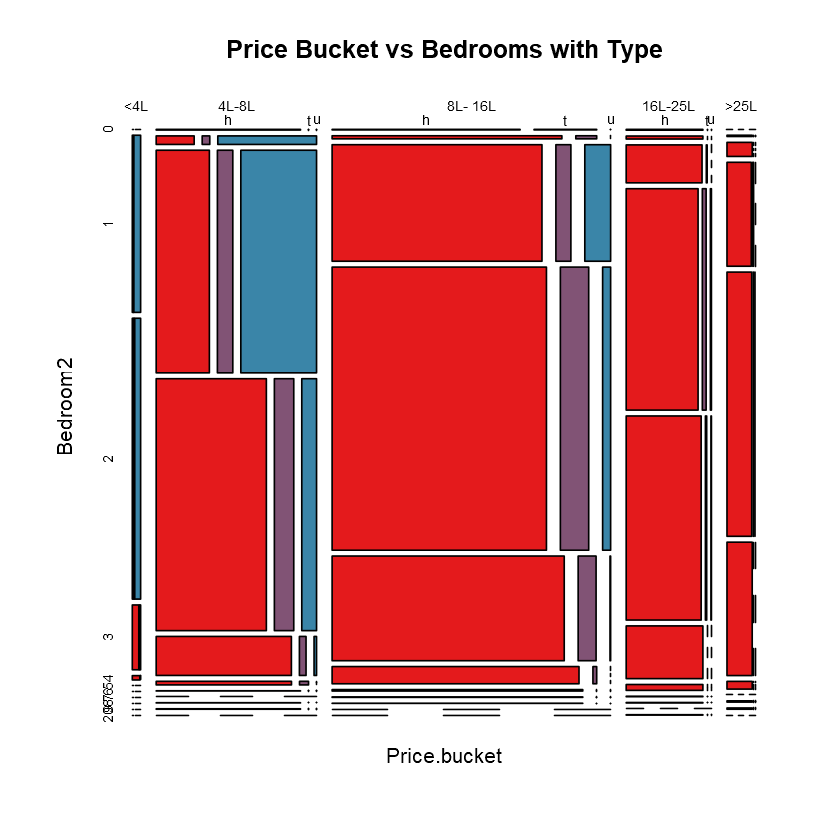

In [77]:
#= Price vs Price.bucket+Bedroom2+Type =#
xtabs(~Price.bucket+Bedroom2+Type, re.analysis)
plot(xtabs(~Price.bucket+Bedroom2+Type, re.analysis), main="Price Bucket vs Bedrooms with Type", col=getPalette(colourCount))


, , Type = h

           Months
Dist.bucket Jan'16 Feb'16 Mar'16 Apr'16 May'16 Jun'16 Jul'16 Aug'16 Sep'16
  very near      0      2      0     10     36     28     17     27     41
  near           0      1      0     54    123     79     46     97    118
  medium         0      5      0     69    147    148     77    120    149
  far            1      5      0     77    227    169     94    159    233
  very far       0      7      0     52    167    151     84    132    167
           Months
Dist.bucket Oct'16 Nov'16 Dec'16 Jan'17 Feb'17 Mar'17 Apr'17 May'17 Jun'17
  very near     22     36     23      0      7     21     18     26      0
  near          68    133     66      0     42     98     75     87      0
  medium       109    180     99      0     91    129    108    156      0
  far          134    264    155      0     96    129    117    150      0
  very far      86    221    116      0     73    117    131    109      0

, , Type = t

           Months
Dist.bucket Jan'1

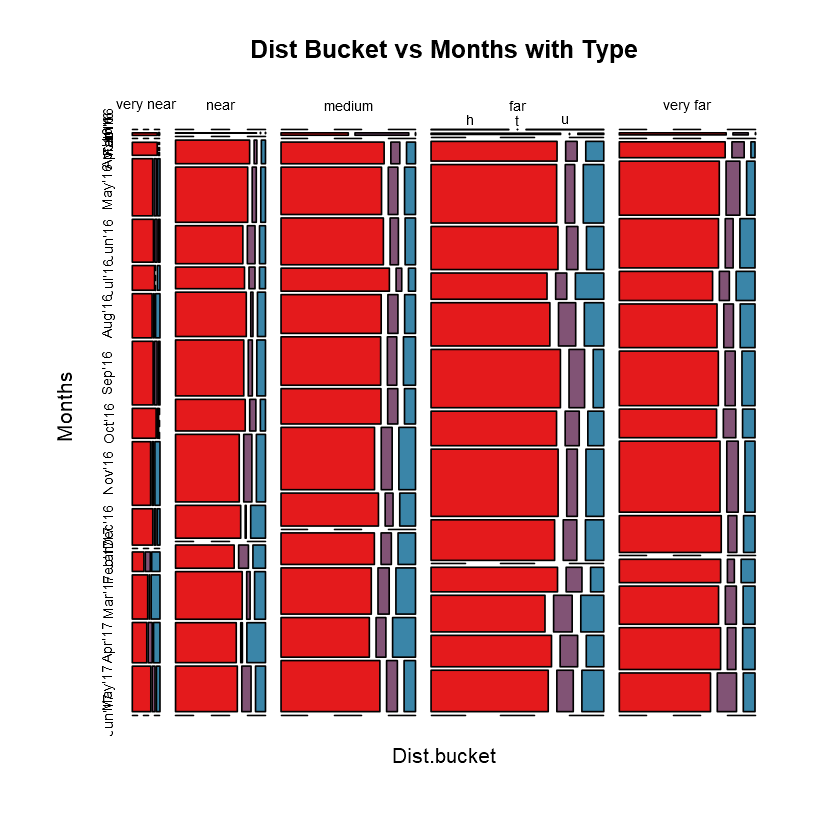

In [78]:
#= Distance vs Dist.bucket+Months+Type =#

xtabs(~Dist.bucket+Months+Type, re.analysis)
plot(xtabs(~Dist.bucket+Months+Type, re.analysis), main="Dist Bucket vs Months with Type", col=getPalette(colourCount))

, , Type = h

           Method
Dist.bucket   PI    S   SA   SP   VB
  very near   31  241    0   21   21
  near       132  769    4   91   91
  medium     178 1060    6  219  124
  far        257 1351    7  211  184
  very far   195 1198    8  143   69

, , Type = t

           Method
Dist.bucket   PI    S   SA   SP   VB
  very near    3   24    0    3    2
  near        19   44    0   11    9
  medium      23  102    0   15   21
  far         29  135    1   30   29
  very far    26  113    0   27   13

, , Type = u

           Method
Dist.bucket   PI    S   SA   SP   VB
  very near    9   29    0    9   13
  near        20   88    0   23   18
  medium      21  147    1   36   19
  far         34  213    1   29   22
  very far    22  143    2   25    6


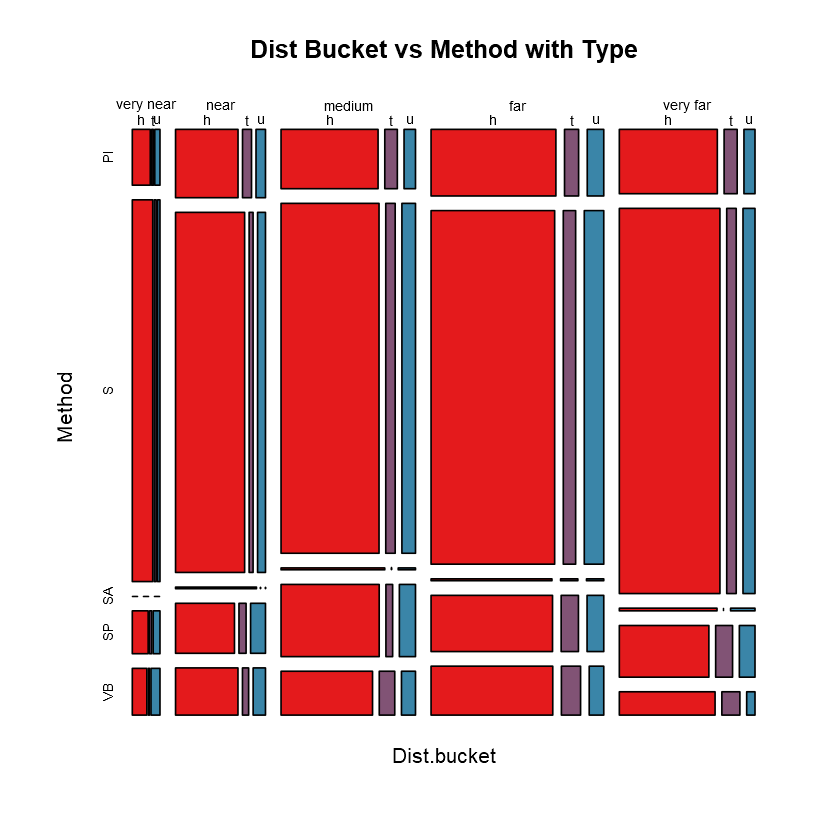

In [79]:
#= Distance vs Dist.bucket+Method+Type =#
xtabs(~Dist.bucket+Method+Type, re.analysis)
plot(xtabs(~Dist.bucket+Method+Type, re.analysis), main="Dist Bucket vs Method with Type", col=getPalette(colourCount))


, , Type = h

           Bedroom2
Dist.bucket   0   1   2   3   4   5   6   7   8   9  20
  very near   0   4 128 137  42   3   0   0   0   0   0
  near        0  16 337 490 196  41   5   1   1   0   0
  medium      1   9 329 797 348  91   9   1   1   1   0
  far         4  12 283 976 558 163   8   2   2   1   1
  very far    3   3 155 917 446  77  10   1   0   1   0

, , Type = t

           Bedroom2
Dist.bucket   0   1   2   3   4   5   6   7   8   9  20
  very near   0   0  16  16   0   0   0   0   0   0   0
  near        0   1  23  57   2   0   0   0   0   0   0
  medium      0   0  34 113  12   2   0   0   0   0   0
  far         0   1  66 125  32   0   0   0   0   0   0
  very far    1   2  26 118  31   1   0   0   0   0   0

, , Type = u

           Bedroom2
Dist.bucket   0   1   2   3   4   5   6   7   8   9  20
  very near   0  13  43   3   1   0   0   0   0   0   0
  near        0  19 115  13   2   0   0   0   0   0   0
  medium      0  22 179  22   1   0   0   0   0   0   0


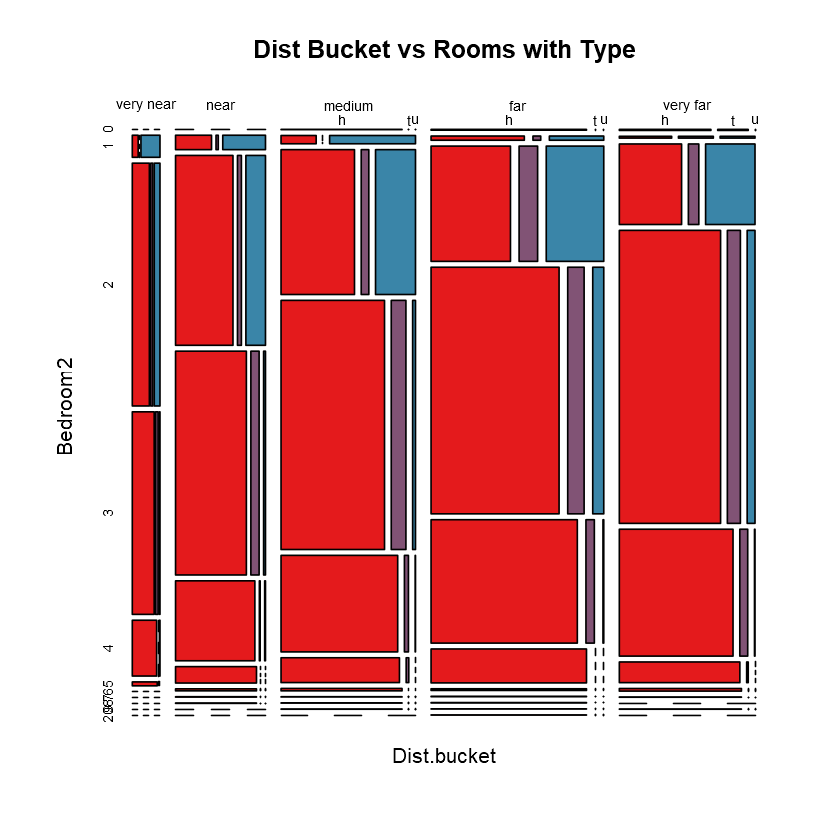

In [80]:
#= Distance vs Dist.bucket+Bedroom2+Type =#
xtabs(~Dist.bucket+Bedroom2+Type, re.analysis)
plot(xtabs(~Dist.bucket+Bedroom2+Type, re.analysis), main="Dist Bucket vs Rooms with Type", col=getPalette(colourCount))


In [82]:
##== CrossTable ==###
#= Price Bucket vs =#
CrossTable(re.analysis$Rooms,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Rooms
#CrossTable(re.analysis$YearBuilt,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs YearBuilt


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                  | re.analysis$Price.bucket 
re.analysis$Rooms |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                1 |        40 |        36 |        15 |         5 |         1 |        97 | 
                  |  1032.814 |     2.449 |    22.873 |     6.445 |     3.056 |           | 
                  |     0.412 |     0.371 |     0.155 |     0.052 |     0.010 |     0.012 | 
                  |     0.328 |     0.015 |     0.004 |     0.004 |     0.002 |           | 
------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                2 |        66 |       983 |       842 |        73 |        

In [83]:
CrossTable(re.analysis$Type,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Type



 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                 | re.analysis$Price.bucket 
re.analysis$Type |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
-----------------|-----------|-----------|-----------|-----------|-----------|-----------|
               h |        28 |      1419 |      3555 |      1205 |       404 |      6611 | 
                 |    50.110 |   118.081 |    22.124 |    39.660 |    16.321 |           | 
                 |     0.004 |     0.215 |     0.538 |     0.182 |     0.061 |     0.804 | 
                 |     0.230 |     0.603 |     0.870 |     0.964 |     0.983 |           | 
-----------------|-----------|-----------|-----------|-----------|-----------|-----------|
               t |         5 |       268 |       365 |        35 |         6 |     

In [84]:
CrossTable(re.analysis$Method,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Method


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                   | re.analysis$Price.bucket 
re.analysis$Method |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
-------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                PI |        37 |       280 |       443 |       178 |        61 |       999 | 
                   |    33.159 |     0.120 |     5.757 |     4.479 |     2.444 |           | 
                   |     0.037 |     0.280 |     0.443 |     0.178 |     0.061 |     0.122 | 
                   |     0.303 |     0.119 |     0.108 |     0.142 |     0.148 |           | 
-------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                 S |        41 |      1563 |      2920 |       868 

In [85]:
CrossTable(re.analysis$Dist.bucket,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Dist.bucket



 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                        | re.analysis$Price.bucket 
re.analysis$Dist.bucket |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
------------------------|-----------|-----------|-----------|-----------|-----------|-----------|
              very near |         8 |        55 |       264 |        61 |        18 |       406 | 
                        |     0.647 |    32.209 |    19.196 |     0.009 |     0.261 |           | 
                        |     0.020 |     0.135 |     0.650 |     0.150 |     0.044 |     0.049 | 
                        |     0.066 |     0.023 |     0.065 |     0.049 |     0.044 |           | 
------------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                   near |  

In [86]:
CrossTable(re.analysis$Months,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Months


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                   | re.analysis$Price.bucket 
re.analysis$Months |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
-------------------|-----------|-----------|-----------|-----------|-----------|-----------|
            Jan'16 |         0 |         0 |         2 |         0 |         0 |         2 | 
                   |     0.030 |     0.572 |     1.018 |     0.304 |     0.100 |           | 
                   |     0.000 |     0.000 |     1.000 |     0.000 |     0.000 |     0.000 | 
                   |     0.000 |     0.000 |     0.000 |     0.000 |     0.000 |           | 
-------------------|-----------|-----------|-----------|-----------|-----------|-----------|
            Feb'16 |         0 |         7 |        17 |         2 

In [87]:
CrossTable(re.analysis$Bathroom,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Bathroom


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                     | re.analysis$Price.bucket 
re.analysis$Bathroom |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
---------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                   0 |         0 |         3 |         8 |         1 |         0 |        12 | 
                     |     0.178 |     0.055 |     0.695 |     0.373 |     0.600 |           | 
                     |     0.000 |     0.250 |     0.667 |     0.083 |     0.000 |     0.001 | 
                     |     0.000 |     0.001 |     0.002 |     0.001 |     0.000 |           | 
---------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                   1 |       119 |      1820 |     

In [88]:
CrossTable(re.analysis$Car,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Car


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                | re.analysis$Price.bucket 
re.analysis$Car |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
----------------|-----------|-----------|-----------|-----------|-----------|-----------|
              0 |         5 |        89 |       433 |        76 |        15 |       618 | 
                |     1.898 |    43.624 |    51.594 |     3.439 |     8.182 |           | 
                |     0.008 |     0.144 |     0.701 |     0.123 |     0.024 |     0.075 | 
                |     0.041 |     0.038 |     0.106 |     0.061 |     0.036 |           | 
----------------|-----------|-----------|-----------|-----------|-----------|-----------|
              1 |       106 |      1237 |      1286 |       277 |        43 |      2949 | 


In [89]:
CrossTable(re.analysis$Bedroom2,re.analysis$Price.bucket,chisq =T,prop.t = F) #Price Bucket vs Bedroom2


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                     | re.analysis$Price.bucket 
re.analysis$Bedroom2 |       <4L |     4L-8L |   8L- 16L |   16L-25L |      >25L | Row Total | 
---------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                   0 |         0 |         3 |         4 |         2 |         0 |         9 | 
                     |     0.134 |     0.070 |     0.050 |     0.291 |     0.450 |           | 
                     |     0.000 |     0.333 |     0.444 |     0.222 |     0.000 |     0.001 | 
                     |     0.000 |     0.001 |     0.001 |     0.002 |     0.000 |           | 
---------------------|-----------|-----------|-----------|-----------|-----------|-----------|
                   1 |        41 |        38 |     

In [90]:
#= Type vs =#
CrossTable(re.analysis$Rooms,re.analysis$Type,chisq =T,prop.t = F) #Type vs Rooms
#CrossTable(re.analysis$YearBuilt,re.analysis$Type,chisq =T,prop.t = F) #Type vs YearBuilt


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                  | re.analysis$Type 
re.analysis$Rooms |         h |         t |         u | Row Total | 
------------------|-----------|-----------|-----------|-----------|
                1 |        35 |         2 |        60 |        97 | 
                  |    23.716 |     4.512 |   219.009 |           | 
                  |     0.361 |     0.021 |     0.619 |     0.012 | 
                  |     0.005 |     0.003 |     0.065 |           | 
------------------|-----------|-----------|-----------|-----------|
                2 |      1135 |       162 |       675 |      1972 | 
                  |   128.246 |     0.005 |   915.268 |           | 
                  |     0.576 |     0.082 |     0.342 |     0.240 | 
                  |     0.172 |     0.239 | 

In [91]:
CrossTable(re.analysis$Method,re.analysis$Type,chisq =T,prop.t = F) #Type vs Method


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                   | re.analysis$Type 
re.analysis$Method |         h |         t |         u | Row Total | 
-------------------|-----------|-----------|-----------|-----------|
                PI |       793 |       100 |       106 |       999 | 
                   |     0.136 |     3.702 |     0.437 |           | 
                   |     0.794 |     0.100 |     0.106 |     0.122 | 
                   |     0.120 |     0.147 |     0.114 |           | 
-------------------|-----------|-----------|-----------|-----------|
                 S |      4619 |       418 |       620 |      5657 | 
                   |     1.056 |     5.199 |     0.627 |           | 
                   |     0.817 |     0.074 |     0.110 |     0.688 | 
                   |     0.699 | 

In [92]:
CrossTable(re.analysis$Dist.bucket,re.analysis$Type,chisq =T,prop.t = F) #Type vs Dist.bucket



 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                        | re.analysis$Type 
re.analysis$Dist.bucket |         h |         t |         u | Row Total | 
------------------------|-----------|-----------|-----------|-----------|
              very near |       314 |        32 |        60 |       406 | 
                        |     0.481 |     0.070 |     4.307 |           | 
                        |     0.773 |     0.079 |     0.148 |     0.049 | 
                        |     0.047 |     0.047 |     0.065 |           | 
------------------------|-----------|-----------|-----------|-----------|
                   near |      1087 |        83 |       149 |      1319 | 
                        |     0.646 |     6.182 |     0.000 |           | 
                        |     0.824 |     0.063 |    

In [93]:
CrossTable(re.analysis$Months,re.analysis$Type,chisq =T,prop.t = F) #Type vs Months


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                   | re.analysis$Type 
re.analysis$Months |         h |         t |         u | Row Total | 
-------------------|-----------|-----------|-----------|-----------|
            Jan'16 |         1 |         0 |         1 |         2 | 
                   |     0.230 |     0.165 |     2.646 |           | 
                   |     0.500 |     0.000 |     0.500 |     0.000 | 
                   |     0.000 |     0.000 |     0.001 |           | 
-------------------|-----------|-----------|-----------|-----------|
            Feb'16 |        20 |         5 |         1 |        26 | 
                   |     0.040 |     3.788 |     1.282 |           | 
                   |     0.769 |     0.192 |     0.038 |     0.003 | 
                   |     0.003 | 

In [94]:
CrossTable(re.analysis$Bedroom2,re.analysis$Type,chisq =T,prop.t = F) #Type vs Bedroom2


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                     | re.analysis$Type 
re.analysis$Bedroom2 |         h |         t |         u | Row Total | 
---------------------|-----------|-----------|-----------|-----------|
                   0 |         8 |         1 |         0 |         9 | 
                     |     0.080 |     0.089 |     1.018 |           | 
                     |     0.889 |     0.111 |     0.000 |     0.001 | 
                     |     0.001 |     0.001 |     0.000 |           | 
---------------------|-----------|-----------|-----------|-----------|
                   1 |        44 |         4 |        63 |       111 | 
                     |    22.959 |     2.914 |   202.602 |           | 
                     |     0.396 |     0.036 |     0.568 |     0.014 | 
           

In [95]:
CrossTable(re.analysis$Bathroom,re.analysis$Type,chisq =T,prop.t = F) #Type vs Bathroom


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                     | re.analysis$Type 
re.analysis$Bathroom |         h |         t |         u | Row Total | 
---------------------|-----------|-----------|-----------|-----------|
                   0 |        10 |         1 |         1 |        12 | 
                     |     0.013 |     0.000 |     0.094 |           | 
                     |     0.833 |     0.083 |     0.083 |     0.001 | 
                     |     0.002 |     0.001 |     0.001 |           | 
---------------------|-----------|-----------|-----------|-----------|
                   1 |      3669 |       168 |       760 |      4597 | 
                     |     0.215 |   118.055 |   110.657 |           | 
                     |     0.798 |     0.037 |     0.165 |     0.559 | 
           

In [96]:
CrossTable(re.analysis$Car,re.analysis$Type,chisq =T,prop.t = F) #Type vs Car


Warning message in chisq.test(t, correct = FALSE, ...):
"Chi-squared approximation may be incorrect"


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  8220 

 
                | re.analysis$Type 
re.analysis$Car |         h |         t |         u | Row Total | 
----------------|-----------|-----------|-----------|-----------|
              0 |       588 |         7 |        23 |       618 | 
                |    16.649 |    38.009 |    31.486 |           | 
                |     0.951 |     0.011 |     0.037 |     0.075 | 
                |     0.089 |     0.010 |     0.025 |           | 
----------------|-----------|-----------|-----------|-----------|
              1 |      1933 |       304 |       712 |      2949 | 
                |    81.167 |    14.977 |   429.053 |           | 
                |     0.655 |     0.103 |     0.241 |     0.359 | 
                |     0.292 |     0.448 |     0.766 |           | 

In [97]:
###=== Writing the data frame to a table for further need ===###
write.table(realestate, file = "F:\\melb.realstate.all.files\\OutputDataSets\\realestate.derived.without.year.csv",row.names=FALSE, na="",col.names=T, sep=",")
